In [1]:
# Step 1: Install FFTW
!apt-get install libfftw3-dev
!apt-get install libfftw3-mpi-dev

# Step 2: Set paths for Dedalus installation
import os
os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

# Step 3: Install Dedalus using pip
!pip3 install dedalus

#2D Rayleigh-Bernard convection in Boussineq approximation

#Importing necessary modules
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import dedalus.public as de
from dedalus.extras import flow_tools
from dedalus.tools import post
import shutil
import random
import time
import h5py
import pathlib
import logging

logger = logging.getLogger('2D RB Convection')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 3,766 kB of archives.
After this operation, 21.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-long3 amd64 3.3.7-1 [308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-quad3 amd64 3.3.7-1 [552 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-single3 amd64 3.3.7-1 [764 kB]
Get:4 http://archive.ubuntu.com/ubuntu bioni

2022-09-18 15:00:08,671 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.


2022-09-18 15:00:08,680 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".


In [12]:
#Defining variables 
Lx, d = (16. ,9.) # (aspect ratio)
xres, zres = (int(128*3), int(64*3)) # Change these to change resolution

#Non-dimensional numbers
Pr = 1
Ra = 1.4e9

In [13]:
#Defining basis and domains
xbasis = de.Fourier('x',xres,interval=(0,Lx),dealias=3/2)
zbasis = de.Chebyshev('z',zres,interval=(0,d),dealias=3/2)

domain = de.Domain([xbasis,zbasis],grid_dtype=np.float64)
problem = de.IVP(domain,variables=['T','p','u','w','Tz','uz','wz'])

DEBUG:domain:Global coeff shape: [192 192]
DEBUG:distributor:Mesh: []


In [14]:
#Defining non-dimensional parameters
problem.parameters['Pr'] = Pr
problem.parameters['Ra'] = Ra
problem.parameters['xres'] = xres

#Main Boussineq Rayleigh-Bernard convection equations
problem.add_equation("dt(u) + dx(p) - (dx(dx(u)) + dz(uz)) = - (u * dx(u) + w * uz)")
problem.add_equation("dt(w) + dz(p) - (dx(dx(w)) + dz(wz)) - (Ra / Pr) * T = - (u * dx(w) + w * wz)")
problem.add_equation("dt(T) - (1 / Pr) * (dx(dx(T)) + dz(Tz)) = - (u * dx(T) + w * Tz)")

#Auxillary equations
problem.add_equation("dz(u) - uz = 0")
problem.add_equation("dz(w) - wz = 0")
problem.add_equation("dz(T) - Tz = 0")

#Continuity equation
problem.add_equation("dx(u) + wz = 0")

#Boundary conditions

#Fixed temperature at top boundary
problem.add_bc("right(T) = 0")

#Fixed flux on bottom boundary
problem.add_bc("left(Tz) = -1")

#Standard fluid dynamics boundary conditions
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0",condition="(nx != 0)")
problem.add_bc("right(p) = 0",condition="(nx == 0)")

DEBUG:problems:Parsing Eqn 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dt(u) + dx(p) - (dx(dx(u)) + dz(uz))
DEBUG:problems:  RHS string form: - (u * dx(u) + w * uz)
DEBUG:problems:  LHS object form: (dt(u) + dx(p)) + (-1*(dx(dx(u)) + dz(uz)))
DEBUG:problems:  RHS object form: -1*((u*dx(u)) + (w*uz))
DEBUG:problems:  M linear form: u
DEBUG:problems:  L linear form: dx(p) + ((-1*dx(dx(u))) + (-1*dz(uz)))
DEBUG:problems:Parsing Eqn 1
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dt(w) + dz(p) - (dx(dx(w)) + dz(wz)) - (Ra / Pr) * T
DEBUG:problems:  RHS string form: - (u * dx(w) + w * wz)
DEBUG:problems:  LHS object form: ((dt(w) + dz(p)) + (-1*(dx(dx(w)) + dz(wz)))) + (-1*((Ra*(Pr**-1))*T))
DEBUG:problems:  RHS object form: -1*((u*dx(w)) + (w*wz))
DEBUG:problems:  M linear form: w
DEBUG:problems:  L linear form: (dz(p) + ((-1*dx(dx(w))) + (-1*dz(wz)))) + ((-1*(Ra*(Pr**-1)))*T)
DEBUG:problems:Parsing Eqn 2
DEBUG:problems:  Condition: True
DEBUG:

In [15]:
#Build solver
solver = problem.build_solver(de.timesteppers.RK111) #RK111 = first order runge kutte timestepping method
logger.info('Solver built')

DEBUG:solvers:Beginning IVP instantiation
INFO:pencil:Building pencil matrix 1/192 (~1%) Elapsed: 0s, Remaining: 7s, Rate: 2.7e+01/s


2022-09-18 15:08:19,841 pencil 0/1 INFO :: Building pencil matrix 1/192 (~1%) Elapsed: 0s, Remaining: 7s, Rate: 2.7e+01/s


INFO:pencil:Building pencil matrix 20/192 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 4.4e+01/s


2022-09-18 15:08:20,263 pencil 0/1 INFO :: Building pencil matrix 20/192 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 4.4e+01/s


INFO:pencil:Building pencil matrix 40/192 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 4.4e+01/s


2022-09-18 15:08:20,709 pencil 0/1 INFO :: Building pencil matrix 40/192 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 4.4e+01/s


INFO:pencil:Building pencil matrix 60/192 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 4.4e+01/s


2022-09-18 15:08:21,174 pencil 0/1 INFO :: Building pencil matrix 60/192 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 4.4e+01/s


INFO:pencil:Building pencil matrix 80/192 (~42%) Elapsed: 2s, Remaining: 3s, Rate: 4.4e+01/s


2022-09-18 15:08:21,640 pencil 0/1 INFO :: Building pencil matrix 80/192 (~42%) Elapsed: 2s, Remaining: 3s, Rate: 4.4e+01/s


INFO:pencil:Building pencil matrix 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 4.3e+01/s


2022-09-18 15:08:22,103 pencil 0/1 INFO :: Building pencil matrix 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 4.3e+01/s


INFO:pencil:Building pencil matrix 120/192 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 4.4e+01/s


2022-09-18 15:08:22,558 pencil 0/1 INFO :: Building pencil matrix 120/192 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 4.4e+01/s


INFO:pencil:Building pencil matrix 140/192 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 4.3e+01/s


2022-09-18 15:08:23,041 pencil 0/1 INFO :: Building pencil matrix 140/192 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 4.3e+01/s


INFO:pencil:Building pencil matrix 160/192 (~83%) Elapsed: 4s, Remaining: 1s, Rate: 4.3e+01/s


2022-09-18 15:08:23,504 pencil 0/1 INFO :: Building pencil matrix 160/192 (~83%) Elapsed: 4s, Remaining: 1s, Rate: 4.3e+01/s


INFO:pencil:Building pencil matrix 180/192 (~94%) Elapsed: 4s, Remaining: 0s, Rate: 4.3e+01/s


2022-09-18 15:08:23,967 pencil 0/1 INFO :: Building pencil matrix 180/192 (~94%) Elapsed: 4s, Remaining: 0s, Rate: 4.3e+01/s


INFO:pencil:Building pencil matrix 192/192 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 4.3e+01/s


2022-09-18 15:08:24,257 pencil 0/1 INFO :: Building pencil matrix 192/192 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 4.3e+01/s


DEBUG:solvers:Finished IVP instantiation
INFO:2D RB Convection:Solver built


2022-09-18 15:08:24,300 2D RB Convection 0/1 INFO :: Solver built


In [16]:
!rm -rf /content/snapshots

In [17]:
#Initial conditions or restart
if not pathlib.Path('restart.h5').exists():

    #Initial conditions
    x, z = domain.all_grids()
    T = solver.state['T']
    Tz = solver.state['Tz']

    #Creating random perturbations
    gshape = domain.dist.grid_layout.global_shape(scales=1)
    slices = domain.dist.grid_layout.slices(scales=1)
    rand = np.random.RandomState(seed=42)
    noise = rand.standard_normal(gshape)[slices]

    #Linear background + perturbations damped at walls
    zb,zt = zbasis.interval
    pert = 1e-1 * noise * (zt - z) * (z - zb)
    T['g'] = pert
    T.differentiate('z',out=Tz)

    #Timestepping and output
    dt = 1e-7
    stop_sim_time = 5  #Change this to change total sim time (total steps = 5/(10**-7) = 5*10**7)
    fh_mode = 'overwrite'

else:
    #Restart
    write,last_dt = solver.load_state('restart.h5', -1)

    #Timestepping and output
    dt = last_dt
    stop_sim_time = 5e-3
    fh_mode = 'append'

DEBUG:basis:Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (384, 192), 0)
DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (192, 192), 1)


In [18]:
#Integration parameters
solver.stop_sim_time  = stop_sim_time
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

In [19]:
#Analysis
shutil.rmtree('snapshots', ignore_errors=True)
snapshots = solver.evaluator.add_file_handler('snapshots',sim_dt=1e-3,max_writes=200,mode=fh_mode)
snapshots.add_task("integ(T,'x')/xres", layout='g', name='<Tx>')
snapshots.add_task("0.5 * (u ** 2 + w ** 2)", layout='g', name='KE')
snapshots.add_task("sqrt(u ** 2 + w ** 2)", layout='g', name='|uvec|')
snapshots.add_system(solver.state)

In [20]:
#CFL criteria (don't touch it)
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.5, max_change=1.5, min_change=1, max_dt=1e-6, threshold=0.05)
CFL.add_velocities(('u', 'w'))

flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u ** 2 + w ** 2)/Ra", name='Re')

In [21]:
# Main loop 
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f minutes' %((end_time-start_time)/60))

INFO:2D RB Convection:Starting loop


2022-09-18 15:09:37,469 2D RB Convection 0/1 INFO :: Starting loop


DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (192, 288), 1)
DEBUG:basis:Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (576, 288), 0)
INFO:2D RB Convection:Iteration: 1, Time: 1.000000e-07, dt: 1.000000e-07


2022-09-18 15:09:38,280 2D RB Convection 0/1 INFO :: Iteration: 1, Time: 1.000000e-07, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11, Time: 1.100000e-06, dt: 1.000000e-07


2022-09-18 15:09:39,496 2D RB Convection 0/1 INFO :: Iteration: 11, Time: 1.100000e-06, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21, Time: 2.600000e-06, dt: 1.500000e-07


2022-09-18 15:09:41,137 2D RB Convection 0/1 INFO :: Iteration: 21, Time: 2.600000e-06, dt: 1.500000e-07


INFO:2D RB Convection:Iteration: 31, Time: 4.850000e-06, dt: 2.250000e-07


2022-09-18 15:09:42,733 2D RB Convection 0/1 INFO :: Iteration: 31, Time: 4.850000e-06, dt: 2.250000e-07


INFO:2D RB Convection:Iteration: 41, Time: 8.225000e-06, dt: 3.375000e-07


2022-09-18 15:09:44,326 2D RB Convection 0/1 INFO :: Iteration: 41, Time: 8.225000e-06, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 51, Time: 1.160000e-05, dt: 3.375000e-07


2022-09-18 15:09:45,419 2D RB Convection 0/1 INFO :: Iteration: 51, Time: 1.160000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 61, Time: 1.497500e-05, dt: 3.375000e-07


2022-09-18 15:09:46,519 2D RB Convection 0/1 INFO :: Iteration: 61, Time: 1.497500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 71, Time: 1.835000e-05, dt: 3.375000e-07


2022-09-18 15:09:47,617 2D RB Convection 0/1 INFO :: Iteration: 71, Time: 1.835000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 81, Time: 2.172500e-05, dt: 3.375000e-07


2022-09-18 15:09:48,714 2D RB Convection 0/1 INFO :: Iteration: 81, Time: 2.172500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 91, Time: 2.510000e-05, dt: 3.375000e-07


2022-09-18 15:09:49,842 2D RB Convection 0/1 INFO :: Iteration: 91, Time: 2.510000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 101, Time: 2.847500e-05, dt: 3.375000e-07


2022-09-18 15:09:50,983 2D RB Convection 0/1 INFO :: Iteration: 101, Time: 2.847500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 111, Time: 3.185000e-05, dt: 3.375000e-07


2022-09-18 15:09:52,081 2D RB Convection 0/1 INFO :: Iteration: 111, Time: 3.185000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 121, Time: 3.522500e-05, dt: 3.375000e-07


2022-09-18 15:09:53,177 2D RB Convection 0/1 INFO :: Iteration: 121, Time: 3.522500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 131, Time: 3.860000e-05, dt: 3.375000e-07


2022-09-18 15:09:54,265 2D RB Convection 0/1 INFO :: Iteration: 131, Time: 3.860000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 141, Time: 4.197500e-05, dt: 3.375000e-07


2022-09-18 15:09:55,776 2D RB Convection 0/1 INFO :: Iteration: 141, Time: 4.197500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 151, Time: 4.535000e-05, dt: 3.375000e-07


2022-09-18 15:09:57,267 2D RB Convection 0/1 INFO :: Iteration: 151, Time: 4.535000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 161, Time: 4.872500e-05, dt: 3.375000e-07


2022-09-18 15:09:58,357 2D RB Convection 0/1 INFO :: Iteration: 161, Time: 4.872500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 171, Time: 5.210000e-05, dt: 3.375000e-07


2022-09-18 15:09:59,455 2D RB Convection 0/1 INFO :: Iteration: 171, Time: 5.210000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 181, Time: 5.547500e-05, dt: 3.375000e-07


2022-09-18 15:10:00,571 2D RB Convection 0/1 INFO :: Iteration: 181, Time: 5.547500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 191, Time: 5.885000e-05, dt: 3.375000e-07


2022-09-18 15:10:01,671 2D RB Convection 0/1 INFO :: Iteration: 191, Time: 5.885000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 201, Time: 6.222500e-05, dt: 3.375000e-07


2022-09-18 15:10:02,810 2D RB Convection 0/1 INFO :: Iteration: 201, Time: 6.222500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 211, Time: 6.560000e-05, dt: 3.375000e-07


2022-09-18 15:10:03,931 2D RB Convection 0/1 INFO :: Iteration: 211, Time: 6.560000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 221, Time: 6.897500e-05, dt: 3.375000e-07


2022-09-18 15:10:05,027 2D RB Convection 0/1 INFO :: Iteration: 221, Time: 6.897500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 231, Time: 7.235000e-05, dt: 3.375000e-07


2022-09-18 15:10:06,145 2D RB Convection 0/1 INFO :: Iteration: 231, Time: 7.235000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 241, Time: 7.572500e-05, dt: 3.375000e-07


2022-09-18 15:10:07,242 2D RB Convection 0/1 INFO :: Iteration: 241, Time: 7.572500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 251, Time: 7.910000e-05, dt: 3.375000e-07


2022-09-18 15:10:08,338 2D RB Convection 0/1 INFO :: Iteration: 251, Time: 7.910000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 261, Time: 8.247500e-05, dt: 3.375000e-07


2022-09-18 15:10:09,438 2D RB Convection 0/1 INFO :: Iteration: 261, Time: 8.247500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 271, Time: 8.585000e-05, dt: 3.375000e-07


2022-09-18 15:10:10,547 2D RB Convection 0/1 INFO :: Iteration: 271, Time: 8.585000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 281, Time: 8.922500e-05, dt: 3.375000e-07


2022-09-18 15:10:11,645 2D RB Convection 0/1 INFO :: Iteration: 281, Time: 8.922500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 291, Time: 9.260000e-05, dt: 3.375000e-07


2022-09-18 15:10:12,763 2D RB Convection 0/1 INFO :: Iteration: 291, Time: 9.260000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 301, Time: 9.597500e-05, dt: 3.375000e-07


2022-09-18 15:10:13,921 2D RB Convection 0/1 INFO :: Iteration: 301, Time: 9.597500e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 311, Time: 9.935000e-05, dt: 3.375000e-07


2022-09-18 15:10:15,010 2D RB Convection 0/1 INFO :: Iteration: 311, Time: 9.935000e-05, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 321, Time: 1.027250e-04, dt: 3.375000e-07


2022-09-18 15:10:16,101 2D RB Convection 0/1 INFO :: Iteration: 321, Time: 1.027250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 331, Time: 1.061000e-04, dt: 3.375000e-07


2022-09-18 15:10:17,204 2D RB Convection 0/1 INFO :: Iteration: 331, Time: 1.061000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 341, Time: 1.094750e-04, dt: 3.375000e-07


2022-09-18 15:10:18,298 2D RB Convection 0/1 INFO :: Iteration: 341, Time: 1.094750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 351, Time: 1.128500e-04, dt: 3.375000e-07


2022-09-18 15:10:19,416 2D RB Convection 0/1 INFO :: Iteration: 351, Time: 1.128500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 361, Time: 1.162250e-04, dt: 3.375000e-07


2022-09-18 15:10:20,512 2D RB Convection 0/1 INFO :: Iteration: 361, Time: 1.162250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 371, Time: 1.196000e-04, dt: 3.375000e-07


2022-09-18 15:10:21,634 2D RB Convection 0/1 INFO :: Iteration: 371, Time: 1.196000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 381, Time: 1.229750e-04, dt: 3.375000e-07


2022-09-18 15:10:22,736 2D RB Convection 0/1 INFO :: Iteration: 381, Time: 1.229750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 391, Time: 1.263500e-04, dt: 3.375000e-07


2022-09-18 15:10:23,830 2D RB Convection 0/1 INFO :: Iteration: 391, Time: 1.263500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 401, Time: 1.297250e-04, dt: 3.375000e-07


2022-09-18 15:10:24,969 2D RB Convection 0/1 INFO :: Iteration: 401, Time: 1.297250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 411, Time: 1.331000e-04, dt: 3.375000e-07


2022-09-18 15:10:26,295 2D RB Convection 0/1 INFO :: Iteration: 411, Time: 1.331000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 421, Time: 1.364750e-04, dt: 3.375000e-07


2022-09-18 15:10:27,400 2D RB Convection 0/1 INFO :: Iteration: 421, Time: 1.364750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 431, Time: 1.398500e-04, dt: 3.375000e-07


2022-09-18 15:10:28,505 2D RB Convection 0/1 INFO :: Iteration: 431, Time: 1.398500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 441, Time: 1.432250e-04, dt: 3.375000e-07


2022-09-18 15:10:29,599 2D RB Convection 0/1 INFO :: Iteration: 441, Time: 1.432250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 451, Time: 1.466000e-04, dt: 3.375000e-07


2022-09-18 15:10:30,706 2D RB Convection 0/1 INFO :: Iteration: 451, Time: 1.466000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 461, Time: 1.499750e-04, dt: 3.375000e-07


2022-09-18 15:10:31,821 2D RB Convection 0/1 INFO :: Iteration: 461, Time: 1.499750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 471, Time: 1.533500e-04, dt: 3.375000e-07


2022-09-18 15:10:32,914 2D RB Convection 0/1 INFO :: Iteration: 471, Time: 1.533500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 481, Time: 1.567250e-04, dt: 3.375000e-07


2022-09-18 15:10:34,033 2D RB Convection 0/1 INFO :: Iteration: 481, Time: 1.567250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 491, Time: 1.601000e-04, dt: 3.375000e-07


2022-09-18 15:10:35,149 2D RB Convection 0/1 INFO :: Iteration: 491, Time: 1.601000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 501, Time: 1.634750e-04, dt: 3.375000e-07


2022-09-18 15:10:36,283 2D RB Convection 0/1 INFO :: Iteration: 501, Time: 1.634750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 511, Time: 1.668500e-04, dt: 3.375000e-07


2022-09-18 15:10:37,387 2D RB Convection 0/1 INFO :: Iteration: 511, Time: 1.668500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 521, Time: 1.702250e-04, dt: 3.375000e-07


2022-09-18 15:10:38,491 2D RB Convection 0/1 INFO :: Iteration: 521, Time: 1.702250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 531, Time: 1.736000e-04, dt: 3.375000e-07


2022-09-18 15:10:39,581 2D RB Convection 0/1 INFO :: Iteration: 531, Time: 1.736000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 541, Time: 1.769750e-04, dt: 3.375000e-07


2022-09-18 15:10:40,679 2D RB Convection 0/1 INFO :: Iteration: 541, Time: 1.769750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 551, Time: 1.803500e-04, dt: 3.375000e-07


2022-09-18 15:10:41,773 2D RB Convection 0/1 INFO :: Iteration: 551, Time: 1.803500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 561, Time: 1.837250e-04, dt: 3.375000e-07


2022-09-18 15:10:42,905 2D RB Convection 0/1 INFO :: Iteration: 561, Time: 1.837250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 571, Time: 1.871000e-04, dt: 3.375000e-07


2022-09-18 15:10:44,003 2D RB Convection 0/1 INFO :: Iteration: 571, Time: 1.871000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 581, Time: 1.904750e-04, dt: 3.375000e-07


2022-09-18 15:10:45,095 2D RB Convection 0/1 INFO :: Iteration: 581, Time: 1.904750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 591, Time: 1.938500e-04, dt: 3.375000e-07


2022-09-18 15:10:46,179 2D RB Convection 0/1 INFO :: Iteration: 591, Time: 1.938500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 601, Time: 1.972250e-04, dt: 3.375000e-07


2022-09-18 15:10:47,322 2D RB Convection 0/1 INFO :: Iteration: 601, Time: 1.972250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 611, Time: 2.006000e-04, dt: 3.375000e-07


2022-09-18 15:10:48,420 2D RB Convection 0/1 INFO :: Iteration: 611, Time: 2.006000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 621, Time: 2.039750e-04, dt: 3.375000e-07


2022-09-18 15:10:49,503 2D RB Convection 0/1 INFO :: Iteration: 621, Time: 2.039750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 631, Time: 2.073500e-04, dt: 3.375000e-07


2022-09-18 15:10:50,608 2D RB Convection 0/1 INFO :: Iteration: 631, Time: 2.073500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 641, Time: 2.107250e-04, dt: 3.375000e-07


2022-09-18 15:10:51,709 2D RB Convection 0/1 INFO :: Iteration: 641, Time: 2.107250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 651, Time: 2.141000e-04, dt: 3.375000e-07


2022-09-18 15:10:52,821 2D RB Convection 0/1 INFO :: Iteration: 651, Time: 2.141000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 661, Time: 2.174750e-04, dt: 3.375000e-07


2022-09-18 15:10:53,922 2D RB Convection 0/1 INFO :: Iteration: 661, Time: 2.174750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 671, Time: 2.208500e-04, dt: 3.375000e-07


2022-09-18 15:10:55,030 2D RB Convection 0/1 INFO :: Iteration: 671, Time: 2.208500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 681, Time: 2.242250e-04, dt: 3.375000e-07


2022-09-18 15:10:56,141 2D RB Convection 0/1 INFO :: Iteration: 681, Time: 2.242250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 691, Time: 2.276000e-04, dt: 3.375000e-07


2022-09-18 15:10:57,272 2D RB Convection 0/1 INFO :: Iteration: 691, Time: 2.276000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 701, Time: 2.309750e-04, dt: 3.375000e-07


2022-09-18 15:10:58,410 2D RB Convection 0/1 INFO :: Iteration: 701, Time: 2.309750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 711, Time: 2.343500e-04, dt: 3.375000e-07


2022-09-18 15:10:59,515 2D RB Convection 0/1 INFO :: Iteration: 711, Time: 2.343500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 721, Time: 2.377250e-04, dt: 3.375000e-07


2022-09-18 15:11:00,635 2D RB Convection 0/1 INFO :: Iteration: 721, Time: 2.377250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 731, Time: 2.411000e-04, dt: 3.375000e-07


2022-09-18 15:11:01,749 2D RB Convection 0/1 INFO :: Iteration: 731, Time: 2.411000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 741, Time: 2.444750e-04, dt: 3.375000e-07


2022-09-18 15:11:02,879 2D RB Convection 0/1 INFO :: Iteration: 741, Time: 2.444750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 751, Time: 2.478500e-04, dt: 3.375000e-07


2022-09-18 15:11:04,000 2D RB Convection 0/1 INFO :: Iteration: 751, Time: 2.478500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 761, Time: 2.512250e-04, dt: 3.375000e-07


2022-09-18 15:11:05,105 2D RB Convection 0/1 INFO :: Iteration: 761, Time: 2.512250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 771, Time: 2.546000e-04, dt: 3.375000e-07


2022-09-18 15:11:06,221 2D RB Convection 0/1 INFO :: Iteration: 771, Time: 2.546000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 781, Time: 2.579750e-04, dt: 3.375000e-07


2022-09-18 15:11:07,314 2D RB Convection 0/1 INFO :: Iteration: 781, Time: 2.579750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 791, Time: 2.613500e-04, dt: 3.375000e-07


2022-09-18 15:11:08,414 2D RB Convection 0/1 INFO :: Iteration: 791, Time: 2.613500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 801, Time: 2.647250e-04, dt: 3.375000e-07


2022-09-18 15:11:09,570 2D RB Convection 0/1 INFO :: Iteration: 801, Time: 2.647250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 811, Time: 2.681000e-04, dt: 3.375000e-07


2022-09-18 15:11:10,672 2D RB Convection 0/1 INFO :: Iteration: 811, Time: 2.681000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 821, Time: 2.714750e-04, dt: 3.375000e-07


2022-09-18 15:11:11,783 2D RB Convection 0/1 INFO :: Iteration: 821, Time: 2.714750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 831, Time: 2.748500e-04, dt: 3.375000e-07


2022-09-18 15:11:12,928 2D RB Convection 0/1 INFO :: Iteration: 831, Time: 2.748500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 841, Time: 2.782250e-04, dt: 3.375000e-07


2022-09-18 15:11:14,055 2D RB Convection 0/1 INFO :: Iteration: 841, Time: 2.782250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 851, Time: 2.816000e-04, dt: 3.375000e-07


2022-09-18 15:11:15,163 2D RB Convection 0/1 INFO :: Iteration: 851, Time: 2.816000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 861, Time: 2.849750e-04, dt: 3.375000e-07


2022-09-18 15:11:16,276 2D RB Convection 0/1 INFO :: Iteration: 861, Time: 2.849750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 871, Time: 2.883500e-04, dt: 3.375000e-07


2022-09-18 15:11:17,375 2D RB Convection 0/1 INFO :: Iteration: 871, Time: 2.883500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 881, Time: 2.917250e-04, dt: 3.375000e-07


2022-09-18 15:11:18,479 2D RB Convection 0/1 INFO :: Iteration: 881, Time: 2.917250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 891, Time: 2.951000e-04, dt: 3.375000e-07


2022-09-18 15:11:19,584 2D RB Convection 0/1 INFO :: Iteration: 891, Time: 2.951000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 901, Time: 2.984750e-04, dt: 3.375000e-07


2022-09-18 15:11:20,734 2D RB Convection 0/1 INFO :: Iteration: 901, Time: 2.984750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 911, Time: 3.018500e-04, dt: 3.375000e-07


2022-09-18 15:11:21,832 2D RB Convection 0/1 INFO :: Iteration: 911, Time: 3.018500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 921, Time: 3.052250e-04, dt: 3.375000e-07


2022-09-18 15:11:22,941 2D RB Convection 0/1 INFO :: Iteration: 921, Time: 3.052250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 931, Time: 3.086000e-04, dt: 3.375000e-07


2022-09-18 15:11:24,073 2D RB Convection 0/1 INFO :: Iteration: 931, Time: 3.086000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 941, Time: 3.119750e-04, dt: 3.375000e-07


2022-09-18 15:11:25,189 2D RB Convection 0/1 INFO :: Iteration: 941, Time: 3.119750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 951, Time: 3.153500e-04, dt: 3.375000e-07


2022-09-18 15:11:26,314 2D RB Convection 0/1 INFO :: Iteration: 951, Time: 3.153500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 961, Time: 3.187250e-04, dt: 3.375000e-07


2022-09-18 15:11:27,424 2D RB Convection 0/1 INFO :: Iteration: 961, Time: 3.187250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 971, Time: 3.221000e-04, dt: 3.375000e-07


2022-09-18 15:11:28,545 2D RB Convection 0/1 INFO :: Iteration: 971, Time: 3.221000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 981, Time: 3.254750e-04, dt: 3.375000e-07


2022-09-18 15:11:29,642 2D RB Convection 0/1 INFO :: Iteration: 981, Time: 3.254750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 991, Time: 3.288500e-04, dt: 3.375000e-07


2022-09-18 15:11:30,732 2D RB Convection 0/1 INFO :: Iteration: 991, Time: 3.288500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1001, Time: 3.322250e-04, dt: 3.375000e-07


2022-09-18 15:11:31,884 2D RB Convection 0/1 INFO :: Iteration: 1001, Time: 3.322250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1011, Time: 3.356000e-04, dt: 3.375000e-07


2022-09-18 15:11:32,995 2D RB Convection 0/1 INFO :: Iteration: 1011, Time: 3.356000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1021, Time: 3.389750e-04, dt: 3.375000e-07


2022-09-18 15:11:34,116 2D RB Convection 0/1 INFO :: Iteration: 1021, Time: 3.389750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1031, Time: 3.423500e-04, dt: 3.375000e-07


2022-09-18 15:11:35,255 2D RB Convection 0/1 INFO :: Iteration: 1031, Time: 3.423500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1041, Time: 3.457250e-04, dt: 3.375000e-07


2022-09-18 15:11:36,347 2D RB Convection 0/1 INFO :: Iteration: 1041, Time: 3.457250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1051, Time: 3.491000e-04, dt: 3.375000e-07


2022-09-18 15:11:37,444 2D RB Convection 0/1 INFO :: Iteration: 1051, Time: 3.491000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1061, Time: 3.524750e-04, dt: 3.375000e-07


2022-09-18 15:11:38,544 2D RB Convection 0/1 INFO :: Iteration: 1061, Time: 3.524750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1071, Time: 3.558500e-04, dt: 3.375000e-07


2022-09-18 15:11:39,655 2D RB Convection 0/1 INFO :: Iteration: 1071, Time: 3.558500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1081, Time: 3.592250e-04, dt: 3.375000e-07


2022-09-18 15:11:40,762 2D RB Convection 0/1 INFO :: Iteration: 1081, Time: 3.592250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1091, Time: 3.626000e-04, dt: 3.375000e-07


2022-09-18 15:11:41,872 2D RB Convection 0/1 INFO :: Iteration: 1091, Time: 3.626000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1101, Time: 3.659750e-04, dt: 3.375000e-07


2022-09-18 15:11:43,031 2D RB Convection 0/1 INFO :: Iteration: 1101, Time: 3.659750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1111, Time: 3.693500e-04, dt: 3.375000e-07


2022-09-18 15:11:44,136 2D RB Convection 0/1 INFO :: Iteration: 1111, Time: 3.693500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1121, Time: 3.727250e-04, dt: 3.375000e-07


2022-09-18 15:11:45,263 2D RB Convection 0/1 INFO :: Iteration: 1121, Time: 3.727250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1131, Time: 3.761000e-04, dt: 3.375000e-07


2022-09-18 15:11:46,375 2D RB Convection 0/1 INFO :: Iteration: 1131, Time: 3.761000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1141, Time: 3.794750e-04, dt: 3.375000e-07


2022-09-18 15:11:47,486 2D RB Convection 0/1 INFO :: Iteration: 1141, Time: 3.794750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1151, Time: 3.828500e-04, dt: 3.375000e-07


2022-09-18 15:11:48,587 2D RB Convection 0/1 INFO :: Iteration: 1151, Time: 3.828500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1161, Time: 3.862250e-04, dt: 3.375000e-07


2022-09-18 15:11:49,687 2D RB Convection 0/1 INFO :: Iteration: 1161, Time: 3.862250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1171, Time: 3.896000e-04, dt: 3.375000e-07


2022-09-18 15:11:50,786 2D RB Convection 0/1 INFO :: Iteration: 1171, Time: 3.896000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1181, Time: 3.929750e-04, dt: 3.375000e-07


2022-09-18 15:11:51,880 2D RB Convection 0/1 INFO :: Iteration: 1181, Time: 3.929750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1191, Time: 3.963500e-04, dt: 3.375000e-07


2022-09-18 15:11:53,006 2D RB Convection 0/1 INFO :: Iteration: 1191, Time: 3.963500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1201, Time: 3.997250e-04, dt: 3.375000e-07


2022-09-18 15:11:54,148 2D RB Convection 0/1 INFO :: Iteration: 1201, Time: 3.997250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1211, Time: 4.031000e-04, dt: 3.375000e-07


2022-09-18 15:11:55,275 2D RB Convection 0/1 INFO :: Iteration: 1211, Time: 4.031000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1221, Time: 4.064750e-04, dt: 3.375000e-07


2022-09-18 15:11:56,383 2D RB Convection 0/1 INFO :: Iteration: 1221, Time: 4.064750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1231, Time: 4.098500e-04, dt: 3.375000e-07


2022-09-18 15:11:57,497 2D RB Convection 0/1 INFO :: Iteration: 1231, Time: 4.098500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1241, Time: 4.132250e-04, dt: 3.375000e-07


2022-09-18 15:11:58,608 2D RB Convection 0/1 INFO :: Iteration: 1241, Time: 4.132250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1251, Time: 4.166000e-04, dt: 3.375000e-07


2022-09-18 15:11:59,706 2D RB Convection 0/1 INFO :: Iteration: 1251, Time: 4.166000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1261, Time: 4.199750e-04, dt: 3.375000e-07


2022-09-18 15:12:00,809 2D RB Convection 0/1 INFO :: Iteration: 1261, Time: 4.199750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1271, Time: 4.233500e-04, dt: 3.375000e-07


2022-09-18 15:12:01,910 2D RB Convection 0/1 INFO :: Iteration: 1271, Time: 4.233500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1281, Time: 4.267250e-04, dt: 3.375000e-07


2022-09-18 15:12:03,034 2D RB Convection 0/1 INFO :: Iteration: 1281, Time: 4.267250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1291, Time: 4.301000e-04, dt: 3.375000e-07


2022-09-18 15:12:04,148 2D RB Convection 0/1 INFO :: Iteration: 1291, Time: 4.301000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1301, Time: 4.334750e-04, dt: 3.375000e-07


2022-09-18 15:12:05,294 2D RB Convection 0/1 INFO :: Iteration: 1301, Time: 4.334750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1311, Time: 4.368500e-04, dt: 3.375000e-07


2022-09-18 15:12:06,456 2D RB Convection 0/1 INFO :: Iteration: 1311, Time: 4.368500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1321, Time: 4.402250e-04, dt: 3.375000e-07


2022-09-18 15:12:07,554 2D RB Convection 0/1 INFO :: Iteration: 1321, Time: 4.402250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1331, Time: 4.436000e-04, dt: 3.375000e-07


2022-09-18 15:12:08,669 2D RB Convection 0/1 INFO :: Iteration: 1331, Time: 4.436000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1341, Time: 4.469750e-04, dt: 3.375000e-07


2022-09-18 15:12:09,759 2D RB Convection 0/1 INFO :: Iteration: 1341, Time: 4.469750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1351, Time: 4.503500e-04, dt: 3.375000e-07


2022-09-18 15:12:10,869 2D RB Convection 0/1 INFO :: Iteration: 1351, Time: 4.503500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1361, Time: 4.537250e-04, dt: 3.375000e-07


2022-09-18 15:12:11,978 2D RB Convection 0/1 INFO :: Iteration: 1361, Time: 4.537250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1371, Time: 4.571000e-04, dt: 3.375000e-07


2022-09-18 15:12:13,107 2D RB Convection 0/1 INFO :: Iteration: 1371, Time: 4.571000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1381, Time: 4.604750e-04, dt: 3.375000e-07


2022-09-18 15:12:14,218 2D RB Convection 0/1 INFO :: Iteration: 1381, Time: 4.604750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1391, Time: 4.638500e-04, dt: 3.375000e-07


2022-09-18 15:12:15,305 2D RB Convection 0/1 INFO :: Iteration: 1391, Time: 4.638500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1401, Time: 4.672250e-04, dt: 3.375000e-07


2022-09-18 15:12:16,461 2D RB Convection 0/1 INFO :: Iteration: 1401, Time: 4.672250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1411, Time: 4.706000e-04, dt: 3.375000e-07


2022-09-18 15:12:17,551 2D RB Convection 0/1 INFO :: Iteration: 1411, Time: 4.706000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1421, Time: 4.739750e-04, dt: 3.375000e-07


2022-09-18 15:12:18,661 2D RB Convection 0/1 INFO :: Iteration: 1421, Time: 4.739750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1431, Time: 4.773500e-04, dt: 3.375000e-07


2022-09-18 15:12:19,769 2D RB Convection 0/1 INFO :: Iteration: 1431, Time: 4.773500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1441, Time: 4.807250e-04, dt: 3.375000e-07


2022-09-18 15:12:20,877 2D RB Convection 0/1 INFO :: Iteration: 1441, Time: 4.807250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1451, Time: 4.841000e-04, dt: 3.375000e-07


2022-09-18 15:12:21,981 2D RB Convection 0/1 INFO :: Iteration: 1451, Time: 4.841000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1461, Time: 4.874750e-04, dt: 3.375000e-07


2022-09-18 15:12:23,080 2D RB Convection 0/1 INFO :: Iteration: 1461, Time: 4.874750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1471, Time: 4.908500e-04, dt: 3.375000e-07


2022-09-18 15:12:24,171 2D RB Convection 0/1 INFO :: Iteration: 1471, Time: 4.908500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1481, Time: 4.942250e-04, dt: 3.375000e-07


2022-09-18 15:12:25,275 2D RB Convection 0/1 INFO :: Iteration: 1481, Time: 4.942250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1491, Time: 4.976000e-04, dt: 3.375000e-07


2022-09-18 15:12:26,380 2D RB Convection 0/1 INFO :: Iteration: 1491, Time: 4.976000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1501, Time: 5.009750e-04, dt: 3.375000e-07


2022-09-18 15:12:27,554 2D RB Convection 0/1 INFO :: Iteration: 1501, Time: 5.009750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1511, Time: 5.043500e-04, dt: 3.375000e-07


2022-09-18 15:12:28,668 2D RB Convection 0/1 INFO :: Iteration: 1511, Time: 5.043500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1521, Time: 5.077250e-04, dt: 3.375000e-07


2022-09-18 15:12:29,767 2D RB Convection 0/1 INFO :: Iteration: 1521, Time: 5.077250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1531, Time: 5.111000e-04, dt: 3.375000e-07


2022-09-18 15:12:30,862 2D RB Convection 0/1 INFO :: Iteration: 1531, Time: 5.111000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1541, Time: 5.144750e-04, dt: 3.375000e-07


2022-09-18 15:12:31,962 2D RB Convection 0/1 INFO :: Iteration: 1541, Time: 5.144750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1551, Time: 5.178500e-04, dt: 3.375000e-07


2022-09-18 15:12:33,066 2D RB Convection 0/1 INFO :: Iteration: 1551, Time: 5.178500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1561, Time: 5.212250e-04, dt: 3.375000e-07


2022-09-18 15:12:34,163 2D RB Convection 0/1 INFO :: Iteration: 1561, Time: 5.212250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1571, Time: 5.246000e-04, dt: 3.375000e-07


2022-09-18 15:12:35,272 2D RB Convection 0/1 INFO :: Iteration: 1571, Time: 5.246000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1581, Time: 5.279750e-04, dt: 3.375000e-07


2022-09-18 15:12:36,364 2D RB Convection 0/1 INFO :: Iteration: 1581, Time: 5.279750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1591, Time: 5.313500e-04, dt: 3.375000e-07


2022-09-18 15:12:37,480 2D RB Convection 0/1 INFO :: Iteration: 1591, Time: 5.313500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1601, Time: 5.347250e-04, dt: 3.375000e-07


2022-09-18 15:12:38,617 2D RB Convection 0/1 INFO :: Iteration: 1601, Time: 5.347250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1611, Time: 5.381000e-04, dt: 3.375000e-07


2022-09-18 15:12:39,717 2D RB Convection 0/1 INFO :: Iteration: 1611, Time: 5.381000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1621, Time: 5.414750e-04, dt: 3.375000e-07


2022-09-18 15:12:40,805 2D RB Convection 0/1 INFO :: Iteration: 1621, Time: 5.414750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1631, Time: 5.448500e-04, dt: 3.375000e-07


2022-09-18 15:12:41,916 2D RB Convection 0/1 INFO :: Iteration: 1631, Time: 5.448500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1641, Time: 5.482250e-04, dt: 3.375000e-07


2022-09-18 15:12:43,025 2D RB Convection 0/1 INFO :: Iteration: 1641, Time: 5.482250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1651, Time: 5.516000e-04, dt: 3.375000e-07


2022-09-18 15:12:44,121 2D RB Convection 0/1 INFO :: Iteration: 1651, Time: 5.516000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1661, Time: 5.549750e-04, dt: 3.375000e-07


2022-09-18 15:12:45,205 2D RB Convection 0/1 INFO :: Iteration: 1661, Time: 5.549750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1671, Time: 5.583500e-04, dt: 3.375000e-07


2022-09-18 15:12:46,313 2D RB Convection 0/1 INFO :: Iteration: 1671, Time: 5.583500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1681, Time: 5.617250e-04, dt: 3.375000e-07


2022-09-18 15:12:47,423 2D RB Convection 0/1 INFO :: Iteration: 1681, Time: 5.617250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1691, Time: 5.651000e-04, dt: 3.375000e-07


2022-09-18 15:12:48,526 2D RB Convection 0/1 INFO :: Iteration: 1691, Time: 5.651000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1701, Time: 5.684750e-04, dt: 3.375000e-07


2022-09-18 15:12:49,664 2D RB Convection 0/1 INFO :: Iteration: 1701, Time: 5.684750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1711, Time: 5.718500e-04, dt: 3.375000e-07


2022-09-18 15:12:50,765 2D RB Convection 0/1 INFO :: Iteration: 1711, Time: 5.718500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1721, Time: 5.752250e-04, dt: 3.375000e-07


2022-09-18 15:12:51,864 2D RB Convection 0/1 INFO :: Iteration: 1721, Time: 5.752250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1731, Time: 5.786000e-04, dt: 3.375000e-07


2022-09-18 15:12:52,980 2D RB Convection 0/1 INFO :: Iteration: 1731, Time: 5.786000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1741, Time: 5.819750e-04, dt: 3.375000e-07


2022-09-18 15:12:54,069 2D RB Convection 0/1 INFO :: Iteration: 1741, Time: 5.819750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1751, Time: 5.853500e-04, dt: 3.375000e-07


2022-09-18 15:12:55,158 2D RB Convection 0/1 INFO :: Iteration: 1751, Time: 5.853500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1761, Time: 5.887250e-04, dt: 3.375000e-07


2022-09-18 15:12:56,257 2D RB Convection 0/1 INFO :: Iteration: 1761, Time: 5.887250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1771, Time: 5.921000e-04, dt: 3.375000e-07


2022-09-18 15:12:57,350 2D RB Convection 0/1 INFO :: Iteration: 1771, Time: 5.921000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1781, Time: 5.954750e-04, dt: 3.375000e-07


2022-09-18 15:12:58,468 2D RB Convection 0/1 INFO :: Iteration: 1781, Time: 5.954750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1791, Time: 5.988500e-04, dt: 3.375000e-07


2022-09-18 15:12:59,576 2D RB Convection 0/1 INFO :: Iteration: 1791, Time: 5.988500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1801, Time: 6.022250e-04, dt: 3.375000e-07


2022-09-18 15:13:00,734 2D RB Convection 0/1 INFO :: Iteration: 1801, Time: 6.022250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1811, Time: 6.056000e-04, dt: 3.375000e-07


2022-09-18 15:13:01,837 2D RB Convection 0/1 INFO :: Iteration: 1811, Time: 6.056000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1821, Time: 6.089750e-04, dt: 3.375000e-07


2022-09-18 15:13:02,942 2D RB Convection 0/1 INFO :: Iteration: 1821, Time: 6.089750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1831, Time: 6.123500e-04, dt: 3.375000e-07


2022-09-18 15:13:04,048 2D RB Convection 0/1 INFO :: Iteration: 1831, Time: 6.123500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1841, Time: 6.157250e-04, dt: 3.375000e-07


2022-09-18 15:13:05,148 2D RB Convection 0/1 INFO :: Iteration: 1841, Time: 6.157250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1851, Time: 6.191000e-04, dt: 3.375000e-07


2022-09-18 15:13:06,256 2D RB Convection 0/1 INFO :: Iteration: 1851, Time: 6.191000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1861, Time: 6.224750e-04, dt: 3.375000e-07


2022-09-18 15:13:07,351 2D RB Convection 0/1 INFO :: Iteration: 1861, Time: 6.224750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1871, Time: 6.258500e-04, dt: 3.375000e-07


2022-09-18 15:13:08,473 2D RB Convection 0/1 INFO :: Iteration: 1871, Time: 6.258500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1881, Time: 6.292250e-04, dt: 3.375000e-07


2022-09-18 15:13:09,573 2D RB Convection 0/1 INFO :: Iteration: 1881, Time: 6.292250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1891, Time: 6.326000e-04, dt: 3.375000e-07


2022-09-18 15:13:10,674 2D RB Convection 0/1 INFO :: Iteration: 1891, Time: 6.326000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1901, Time: 6.359750e-04, dt: 3.375000e-07


2022-09-18 15:13:11,812 2D RB Convection 0/1 INFO :: Iteration: 1901, Time: 6.359750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1911, Time: 6.393500e-04, dt: 3.375000e-07


2022-09-18 15:13:12,941 2D RB Convection 0/1 INFO :: Iteration: 1911, Time: 6.393500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1921, Time: 6.427250e-04, dt: 3.375000e-07


2022-09-18 15:13:14,060 2D RB Convection 0/1 INFO :: Iteration: 1921, Time: 6.427250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1931, Time: 6.461000e-04, dt: 3.375000e-07


2022-09-18 15:13:15,154 2D RB Convection 0/1 INFO :: Iteration: 1931, Time: 6.461000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1941, Time: 6.494750e-04, dt: 3.375000e-07


2022-09-18 15:13:16,252 2D RB Convection 0/1 INFO :: Iteration: 1941, Time: 6.494750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1951, Time: 6.528500e-04, dt: 3.375000e-07


2022-09-18 15:13:17,355 2D RB Convection 0/1 INFO :: Iteration: 1951, Time: 6.528500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1961, Time: 6.562250e-04, dt: 3.375000e-07


2022-09-18 15:13:18,441 2D RB Convection 0/1 INFO :: Iteration: 1961, Time: 6.562250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1971, Time: 6.596000e-04, dt: 3.375000e-07


2022-09-18 15:13:19,561 2D RB Convection 0/1 INFO :: Iteration: 1971, Time: 6.596000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1981, Time: 6.629750e-04, dt: 3.375000e-07


2022-09-18 15:13:20,654 2D RB Convection 0/1 INFO :: Iteration: 1981, Time: 6.629750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 1991, Time: 6.663500e-04, dt: 3.375000e-07


2022-09-18 15:13:21,751 2D RB Convection 0/1 INFO :: Iteration: 1991, Time: 6.663500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2001, Time: 6.697250e-04, dt: 3.375000e-07


2022-09-18 15:13:22,896 2D RB Convection 0/1 INFO :: Iteration: 2001, Time: 6.697250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2011, Time: 6.731000e-04, dt: 3.375000e-07


2022-09-18 15:13:24,003 2D RB Convection 0/1 INFO :: Iteration: 2011, Time: 6.731000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2021, Time: 6.764750e-04, dt: 3.375000e-07


2022-09-18 15:13:25,095 2D RB Convection 0/1 INFO :: Iteration: 2021, Time: 6.764750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2031, Time: 6.798500e-04, dt: 3.375000e-07


2022-09-18 15:13:26,207 2D RB Convection 0/1 INFO :: Iteration: 2031, Time: 6.798500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2041, Time: 6.832250e-04, dt: 3.375000e-07


2022-09-18 15:13:27,322 2D RB Convection 0/1 INFO :: Iteration: 2041, Time: 6.832250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2051, Time: 6.866000e-04, dt: 3.375000e-07


2022-09-18 15:13:28,417 2D RB Convection 0/1 INFO :: Iteration: 2051, Time: 6.866000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2061, Time: 6.899750e-04, dt: 3.375000e-07


2022-09-18 15:13:29,536 2D RB Convection 0/1 INFO :: Iteration: 2061, Time: 6.899750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2071, Time: 6.933500e-04, dt: 3.375000e-07


2022-09-18 15:13:30,669 2D RB Convection 0/1 INFO :: Iteration: 2071, Time: 6.933500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2081, Time: 6.967250e-04, dt: 3.375000e-07


2022-09-18 15:13:31,768 2D RB Convection 0/1 INFO :: Iteration: 2081, Time: 6.967250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2091, Time: 7.001000e-04, dt: 3.375000e-07


2022-09-18 15:13:32,870 2D RB Convection 0/1 INFO :: Iteration: 2091, Time: 7.001000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2101, Time: 7.034750e-04, dt: 3.375000e-07


2022-09-18 15:13:34,286 2D RB Convection 0/1 INFO :: Iteration: 2101, Time: 7.034750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2111, Time: 7.068500e-04, dt: 3.375000e-07


2022-09-18 15:13:36,208 2D RB Convection 0/1 INFO :: Iteration: 2111, Time: 7.068500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2121, Time: 7.102250e-04, dt: 3.375000e-07


2022-09-18 15:13:37,918 2D RB Convection 0/1 INFO :: Iteration: 2121, Time: 7.102250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2131, Time: 7.136000e-04, dt: 3.375000e-07


2022-09-18 15:13:39,726 2D RB Convection 0/1 INFO :: Iteration: 2131, Time: 7.136000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2141, Time: 7.169750e-04, dt: 3.375000e-07


2022-09-18 15:13:42,091 2D RB Convection 0/1 INFO :: Iteration: 2141, Time: 7.169750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2151, Time: 7.203500e-04, dt: 3.375000e-07


2022-09-18 15:13:43,210 2D RB Convection 0/1 INFO :: Iteration: 2151, Time: 7.203500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2161, Time: 7.237250e-04, dt: 3.375000e-07


2022-09-18 15:13:45,267 2D RB Convection 0/1 INFO :: Iteration: 2161, Time: 7.237250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2171, Time: 7.271000e-04, dt: 3.375000e-07


2022-09-18 15:13:47,111 2D RB Convection 0/1 INFO :: Iteration: 2171, Time: 7.271000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2181, Time: 7.304750e-04, dt: 3.375000e-07


2022-09-18 15:13:48,766 2D RB Convection 0/1 INFO :: Iteration: 2181, Time: 7.304750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2191, Time: 7.338500e-04, dt: 3.375000e-07


2022-09-18 15:13:50,420 2D RB Convection 0/1 INFO :: Iteration: 2191, Time: 7.338500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2201, Time: 7.372250e-04, dt: 3.375000e-07


2022-09-18 15:13:52,152 2D RB Convection 0/1 INFO :: Iteration: 2201, Time: 7.372250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2211, Time: 7.406000e-04, dt: 3.375000e-07


2022-09-18 15:13:53,734 2D RB Convection 0/1 INFO :: Iteration: 2211, Time: 7.406000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2221, Time: 7.439750e-04, dt: 3.375000e-07


2022-09-18 15:13:54,844 2D RB Convection 0/1 INFO :: Iteration: 2221, Time: 7.439750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2231, Time: 7.473500e-04, dt: 3.375000e-07


2022-09-18 15:13:55,966 2D RB Convection 0/1 INFO :: Iteration: 2231, Time: 7.473500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2241, Time: 7.507250e-04, dt: 3.375000e-07


2022-09-18 15:13:57,096 2D RB Convection 0/1 INFO :: Iteration: 2241, Time: 7.507250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2251, Time: 7.541000e-04, dt: 3.375000e-07


2022-09-18 15:13:58,212 2D RB Convection 0/1 INFO :: Iteration: 2251, Time: 7.541000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2261, Time: 7.574750e-04, dt: 3.375000e-07


2022-09-18 15:13:59,328 2D RB Convection 0/1 INFO :: Iteration: 2261, Time: 7.574750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2271, Time: 7.608500e-04, dt: 3.375000e-07


2022-09-18 15:14:00,478 2D RB Convection 0/1 INFO :: Iteration: 2271, Time: 7.608500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2281, Time: 7.642250e-04, dt: 3.375000e-07


2022-09-18 15:14:01,604 2D RB Convection 0/1 INFO :: Iteration: 2281, Time: 7.642250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2291, Time: 7.676000e-04, dt: 3.375000e-07


2022-09-18 15:14:02,756 2D RB Convection 0/1 INFO :: Iteration: 2291, Time: 7.676000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2301, Time: 7.709750e-04, dt: 3.375000e-07


2022-09-18 15:14:03,925 2D RB Convection 0/1 INFO :: Iteration: 2301, Time: 7.709750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2311, Time: 7.743500e-04, dt: 3.375000e-07


2022-09-18 15:14:05,033 2D RB Convection 0/1 INFO :: Iteration: 2311, Time: 7.743500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2321, Time: 7.777250e-04, dt: 3.375000e-07


2022-09-18 15:14:07,011 2D RB Convection 0/1 INFO :: Iteration: 2321, Time: 7.777250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2331, Time: 7.811000e-04, dt: 3.375000e-07


2022-09-18 15:14:08,427 2D RB Convection 0/1 INFO :: Iteration: 2331, Time: 7.811000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2341, Time: 7.844750e-04, dt: 3.375000e-07


2022-09-18 15:14:10,448 2D RB Convection 0/1 INFO :: Iteration: 2341, Time: 7.844750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2351, Time: 7.878500e-04, dt: 3.375000e-07


2022-09-18 15:14:11,570 2D RB Convection 0/1 INFO :: Iteration: 2351, Time: 7.878500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2361, Time: 7.912250e-04, dt: 3.375000e-07


2022-09-18 15:14:12,691 2D RB Convection 0/1 INFO :: Iteration: 2361, Time: 7.912250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2371, Time: 7.946000e-04, dt: 3.375000e-07


2022-09-18 15:14:13,804 2D RB Convection 0/1 INFO :: Iteration: 2371, Time: 7.946000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2381, Time: 7.979750e-04, dt: 3.375000e-07


2022-09-18 15:14:14,901 2D RB Convection 0/1 INFO :: Iteration: 2381, Time: 7.979750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2391, Time: 8.013500e-04, dt: 3.375000e-07


2022-09-18 15:14:16,018 2D RB Convection 0/1 INFO :: Iteration: 2391, Time: 8.013500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2401, Time: 8.047250e-04, dt: 3.375000e-07


2022-09-18 15:14:17,154 2D RB Convection 0/1 INFO :: Iteration: 2401, Time: 8.047250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2411, Time: 8.081000e-04, dt: 3.375000e-07


2022-09-18 15:14:18,253 2D RB Convection 0/1 INFO :: Iteration: 2411, Time: 8.081000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2421, Time: 8.114750e-04, dt: 3.375000e-07


2022-09-18 15:14:19,360 2D RB Convection 0/1 INFO :: Iteration: 2421, Time: 8.114750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2431, Time: 8.148500e-04, dt: 3.375000e-07


2022-09-18 15:14:20,478 2D RB Convection 0/1 INFO :: Iteration: 2431, Time: 8.148500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2441, Time: 8.182250e-04, dt: 3.375000e-07


2022-09-18 15:14:21,601 2D RB Convection 0/1 INFO :: Iteration: 2441, Time: 8.182250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2451, Time: 8.216000e-04, dt: 3.375000e-07


2022-09-18 15:14:22,712 2D RB Convection 0/1 INFO :: Iteration: 2451, Time: 8.216000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2461, Time: 8.249750e-04, dt: 3.375000e-07


2022-09-18 15:14:23,830 2D RB Convection 0/1 INFO :: Iteration: 2461, Time: 8.249750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2471, Time: 8.283500e-04, dt: 3.375000e-07


2022-09-18 15:14:24,923 2D RB Convection 0/1 INFO :: Iteration: 2471, Time: 8.283500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2481, Time: 8.317250e-04, dt: 3.375000e-07


2022-09-18 15:14:26,039 2D RB Convection 0/1 INFO :: Iteration: 2481, Time: 8.317250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2491, Time: 8.351000e-04, dt: 3.375000e-07


2022-09-18 15:14:27,160 2D RB Convection 0/1 INFO :: Iteration: 2491, Time: 8.351000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2501, Time: 8.384750e-04, dt: 3.375000e-07


2022-09-18 15:14:28,300 2D RB Convection 0/1 INFO :: Iteration: 2501, Time: 8.384750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2511, Time: 8.418500e-04, dt: 3.375000e-07


2022-09-18 15:14:29,417 2D RB Convection 0/1 INFO :: Iteration: 2511, Time: 8.418500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2521, Time: 8.452250e-04, dt: 3.375000e-07


2022-09-18 15:14:30,541 2D RB Convection 0/1 INFO :: Iteration: 2521, Time: 8.452250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2531, Time: 8.486000e-04, dt: 3.375000e-07


2022-09-18 15:14:31,654 2D RB Convection 0/1 INFO :: Iteration: 2531, Time: 8.486000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2541, Time: 8.519750e-04, dt: 3.375000e-07


2022-09-18 15:14:32,792 2D RB Convection 0/1 INFO :: Iteration: 2541, Time: 8.519750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2551, Time: 8.553500e-04, dt: 3.375000e-07


2022-09-18 15:14:33,933 2D RB Convection 0/1 INFO :: Iteration: 2551, Time: 8.553500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2561, Time: 8.587250e-04, dt: 3.375000e-07


2022-09-18 15:14:35,056 2D RB Convection 0/1 INFO :: Iteration: 2561, Time: 8.587250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2571, Time: 8.621000e-04, dt: 3.375000e-07


2022-09-18 15:14:36,176 2D RB Convection 0/1 INFO :: Iteration: 2571, Time: 8.621000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2581, Time: 8.654750e-04, dt: 3.375000e-07


2022-09-18 15:14:37,285 2D RB Convection 0/1 INFO :: Iteration: 2581, Time: 8.654750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2591, Time: 8.688500e-04, dt: 3.375000e-07


2022-09-18 15:14:38,390 2D RB Convection 0/1 INFO :: Iteration: 2591, Time: 8.688500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2601, Time: 8.722250e-04, dt: 3.375000e-07


2022-09-18 15:14:39,535 2D RB Convection 0/1 INFO :: Iteration: 2601, Time: 8.722250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2611, Time: 8.756000e-04, dt: 3.375000e-07


2022-09-18 15:14:40,647 2D RB Convection 0/1 INFO :: Iteration: 2611, Time: 8.756000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2621, Time: 8.789750e-04, dt: 3.375000e-07


2022-09-18 15:14:41,756 2D RB Convection 0/1 INFO :: Iteration: 2621, Time: 8.789750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2631, Time: 8.823500e-04, dt: 3.375000e-07


2022-09-18 15:14:42,895 2D RB Convection 0/1 INFO :: Iteration: 2631, Time: 8.823500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2641, Time: 8.857250e-04, dt: 3.375000e-07


2022-09-18 15:14:44,011 2D RB Convection 0/1 INFO :: Iteration: 2641, Time: 8.857250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2651, Time: 8.891000e-04, dt: 3.375000e-07


2022-09-18 15:14:45,113 2D RB Convection 0/1 INFO :: Iteration: 2651, Time: 8.891000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2661, Time: 8.924750e-04, dt: 3.375000e-07


2022-09-18 15:14:46,230 2D RB Convection 0/1 INFO :: Iteration: 2661, Time: 8.924750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2671, Time: 8.958500e-04, dt: 3.375000e-07


2022-09-18 15:14:47,343 2D RB Convection 0/1 INFO :: Iteration: 2671, Time: 8.958500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2681, Time: 8.992250e-04, dt: 3.375000e-07


2022-09-18 15:14:48,454 2D RB Convection 0/1 INFO :: Iteration: 2681, Time: 8.992250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2691, Time: 9.026000e-04, dt: 3.375000e-07


2022-09-18 15:14:49,574 2D RB Convection 0/1 INFO :: Iteration: 2691, Time: 9.026000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2701, Time: 9.059750e-04, dt: 3.375000e-07


2022-09-18 15:14:50,724 2D RB Convection 0/1 INFO :: Iteration: 2701, Time: 9.059750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2711, Time: 9.093500e-04, dt: 3.375000e-07


2022-09-18 15:14:51,842 2D RB Convection 0/1 INFO :: Iteration: 2711, Time: 9.093500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2721, Time: 9.127250e-04, dt: 3.375000e-07


2022-09-18 15:14:52,979 2D RB Convection 0/1 INFO :: Iteration: 2721, Time: 9.127250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2731, Time: 9.161000e-04, dt: 3.375000e-07


2022-09-18 15:14:54,089 2D RB Convection 0/1 INFO :: Iteration: 2731, Time: 9.161000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2741, Time: 9.194750e-04, dt: 3.375000e-07


2022-09-18 15:14:55,207 2D RB Convection 0/1 INFO :: Iteration: 2741, Time: 9.194750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2751, Time: 9.228500e-04, dt: 3.375000e-07


2022-09-18 15:14:56,317 2D RB Convection 0/1 INFO :: Iteration: 2751, Time: 9.228500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2761, Time: 9.262250e-04, dt: 3.375000e-07


2022-09-18 15:14:57,448 2D RB Convection 0/1 INFO :: Iteration: 2761, Time: 9.262250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2771, Time: 9.296000e-04, dt: 3.375000e-07


2022-09-18 15:14:58,568 2D RB Convection 0/1 INFO :: Iteration: 2771, Time: 9.296000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2781, Time: 9.329750e-04, dt: 3.375000e-07


2022-09-18 15:14:59,672 2D RB Convection 0/1 INFO :: Iteration: 2781, Time: 9.329750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2791, Time: 9.363500e-04, dt: 3.375000e-07


2022-09-18 15:15:00,798 2D RB Convection 0/1 INFO :: Iteration: 2791, Time: 9.363500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2801, Time: 9.397250e-04, dt: 3.375000e-07


2022-09-18 15:15:01,974 2D RB Convection 0/1 INFO :: Iteration: 2801, Time: 9.397250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2811, Time: 9.431000e-04, dt: 3.375000e-07


2022-09-18 15:15:03,107 2D RB Convection 0/1 INFO :: Iteration: 2811, Time: 9.431000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2821, Time: 9.464750e-04, dt: 3.375000e-07


2022-09-18 15:15:04,255 2D RB Convection 0/1 INFO :: Iteration: 2821, Time: 9.464750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2831, Time: 9.498500e-04, dt: 3.375000e-07


2022-09-18 15:15:05,381 2D RB Convection 0/1 INFO :: Iteration: 2831, Time: 9.498500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2841, Time: 9.532250e-04, dt: 3.375000e-07


2022-09-18 15:15:06,499 2D RB Convection 0/1 INFO :: Iteration: 2841, Time: 9.532250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2851, Time: 9.566000e-04, dt: 3.375000e-07


2022-09-18 15:15:07,601 2D RB Convection 0/1 INFO :: Iteration: 2851, Time: 9.566000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2861, Time: 9.599750e-04, dt: 3.375000e-07


2022-09-18 15:15:08,718 2D RB Convection 0/1 INFO :: Iteration: 2861, Time: 9.599750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2871, Time: 9.633500e-04, dt: 3.375000e-07


2022-09-18 15:15:09,805 2D RB Convection 0/1 INFO :: Iteration: 2871, Time: 9.633500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2881, Time: 9.667250e-04, dt: 3.375000e-07


2022-09-18 15:15:10,903 2D RB Convection 0/1 INFO :: Iteration: 2881, Time: 9.667250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2891, Time: 9.701000e-04, dt: 3.375000e-07


2022-09-18 15:15:11,997 2D RB Convection 0/1 INFO :: Iteration: 2891, Time: 9.701000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2901, Time: 9.734750e-04, dt: 3.375000e-07


2022-09-18 15:15:13,168 2D RB Convection 0/1 INFO :: Iteration: 2901, Time: 9.734750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2911, Time: 9.768500e-04, dt: 3.375000e-07


2022-09-18 15:15:14,254 2D RB Convection 0/1 INFO :: Iteration: 2911, Time: 9.768500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2921, Time: 9.802250e-04, dt: 3.375000e-07


2022-09-18 15:15:15,366 2D RB Convection 0/1 INFO :: Iteration: 2921, Time: 9.802250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2931, Time: 9.836000e-04, dt: 3.375000e-07


2022-09-18 15:15:16,627 2D RB Convection 0/1 INFO :: Iteration: 2931, Time: 9.836000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2941, Time: 9.869750e-04, dt: 3.375000e-07


2022-09-18 15:15:18,054 2D RB Convection 0/1 INFO :: Iteration: 2941, Time: 9.869750e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2951, Time: 9.903500e-04, dt: 3.375000e-07


2022-09-18 15:15:19,155 2D RB Convection 0/1 INFO :: Iteration: 2951, Time: 9.903500e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2961, Time: 9.937250e-04, dt: 3.375000e-07


2022-09-18 15:15:20,262 2D RB Convection 0/1 INFO :: Iteration: 2961, Time: 9.937250e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2971, Time: 9.971000e-04, dt: 3.375000e-07


2022-09-18 15:15:21,361 2D RB Convection 0/1 INFO :: Iteration: 2971, Time: 9.971000e-04, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2981, Time: 1.000475e-03, dt: 3.375000e-07


2022-09-18 15:15:22,518 2D RB Convection 0/1 INFO :: Iteration: 2981, Time: 1.000475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 2991, Time: 1.003850e-03, dt: 3.375000e-07


2022-09-18 15:15:23,625 2D RB Convection 0/1 INFO :: Iteration: 2991, Time: 1.003850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3001, Time: 1.007225e-03, dt: 3.375000e-07


2022-09-18 15:15:24,760 2D RB Convection 0/1 INFO :: Iteration: 3001, Time: 1.007225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3011, Time: 1.010600e-03, dt: 3.375000e-07


2022-09-18 15:15:25,891 2D RB Convection 0/1 INFO :: Iteration: 3011, Time: 1.010600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3021, Time: 1.013975e-03, dt: 3.375000e-07


2022-09-18 15:15:27,045 2D RB Convection 0/1 INFO :: Iteration: 3021, Time: 1.013975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3031, Time: 1.017350e-03, dt: 3.375000e-07


2022-09-18 15:15:28,476 2D RB Convection 0/1 INFO :: Iteration: 3031, Time: 1.017350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3041, Time: 1.020725e-03, dt: 3.375000e-07


2022-09-18 15:15:29,571 2D RB Convection 0/1 INFO :: Iteration: 3041, Time: 1.020725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3051, Time: 1.024100e-03, dt: 3.375000e-07


2022-09-18 15:15:30,674 2D RB Convection 0/1 INFO :: Iteration: 3051, Time: 1.024100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3061, Time: 1.027475e-03, dt: 3.375000e-07


2022-09-18 15:15:31,782 2D RB Convection 0/1 INFO :: Iteration: 3061, Time: 1.027475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3071, Time: 1.030850e-03, dt: 3.375000e-07


2022-09-18 15:15:32,896 2D RB Convection 0/1 INFO :: Iteration: 3071, Time: 1.030850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3081, Time: 1.034225e-03, dt: 3.375000e-07


2022-09-18 15:15:34,034 2D RB Convection 0/1 INFO :: Iteration: 3081, Time: 1.034225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3091, Time: 1.037600e-03, dt: 3.375000e-07


2022-09-18 15:15:35,145 2D RB Convection 0/1 INFO :: Iteration: 3091, Time: 1.037600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3101, Time: 1.040975e-03, dt: 3.375000e-07


2022-09-18 15:15:36,310 2D RB Convection 0/1 INFO :: Iteration: 3101, Time: 1.040975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3111, Time: 1.044350e-03, dt: 3.375000e-07


2022-09-18 15:15:37,422 2D RB Convection 0/1 INFO :: Iteration: 3111, Time: 1.044350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3121, Time: 1.047725e-03, dt: 3.375000e-07


2022-09-18 15:15:38,540 2D RB Convection 0/1 INFO :: Iteration: 3121, Time: 1.047725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3131, Time: 1.051100e-03, dt: 3.375000e-07


2022-09-18 15:15:39,640 2D RB Convection 0/1 INFO :: Iteration: 3131, Time: 1.051100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3141, Time: 1.054475e-03, dt: 3.375000e-07


2022-09-18 15:15:40,745 2D RB Convection 0/1 INFO :: Iteration: 3141, Time: 1.054475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3151, Time: 1.057850e-03, dt: 3.375000e-07


2022-09-18 15:15:41,847 2D RB Convection 0/1 INFO :: Iteration: 3151, Time: 1.057850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3161, Time: 1.061225e-03, dt: 3.375000e-07


2022-09-18 15:15:42,983 2D RB Convection 0/1 INFO :: Iteration: 3161, Time: 1.061225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3171, Time: 1.064600e-03, dt: 3.375000e-07


2022-09-18 15:15:44,095 2D RB Convection 0/1 INFO :: Iteration: 3171, Time: 1.064600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3181, Time: 1.067975e-03, dt: 3.375000e-07


2022-09-18 15:15:45,202 2D RB Convection 0/1 INFO :: Iteration: 3181, Time: 1.067975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3191, Time: 1.071350e-03, dt: 3.375000e-07


2022-09-18 15:15:46,336 2D RB Convection 0/1 INFO :: Iteration: 3191, Time: 1.071350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3201, Time: 1.074725e-03, dt: 3.375000e-07


2022-09-18 15:15:47,519 2D RB Convection 0/1 INFO :: Iteration: 3201, Time: 1.074725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3211, Time: 1.078100e-03, dt: 3.375000e-07


2022-09-18 15:15:48,635 2D RB Convection 0/1 INFO :: Iteration: 3211, Time: 1.078100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3221, Time: 1.081475e-03, dt: 3.375000e-07


2022-09-18 15:15:49,742 2D RB Convection 0/1 INFO :: Iteration: 3221, Time: 1.081475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3231, Time: 1.084850e-03, dt: 3.375000e-07


2022-09-18 15:15:50,844 2D RB Convection 0/1 INFO :: Iteration: 3231, Time: 1.084850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3241, Time: 1.088225e-03, dt: 3.375000e-07


2022-09-18 15:15:51,938 2D RB Convection 0/1 INFO :: Iteration: 3241, Time: 1.088225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3251, Time: 1.091600e-03, dt: 3.375000e-07


2022-09-18 15:15:53,052 2D RB Convection 0/1 INFO :: Iteration: 3251, Time: 1.091600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3261, Time: 1.094975e-03, dt: 3.375000e-07


2022-09-18 15:15:54,165 2D RB Convection 0/1 INFO :: Iteration: 3261, Time: 1.094975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3271, Time: 1.098350e-03, dt: 3.375000e-07


2022-09-18 15:15:55,279 2D RB Convection 0/1 INFO :: Iteration: 3271, Time: 1.098350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3281, Time: 1.101725e-03, dt: 3.375000e-07


2022-09-18 15:15:56,829 2D RB Convection 0/1 INFO :: Iteration: 3281, Time: 1.101725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3291, Time: 1.105100e-03, dt: 3.375000e-07


2022-09-18 15:15:57,950 2D RB Convection 0/1 INFO :: Iteration: 3291, Time: 1.105100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3301, Time: 1.108475e-03, dt: 3.375000e-07


2022-09-18 15:15:59,112 2D RB Convection 0/1 INFO :: Iteration: 3301, Time: 1.108475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3311, Time: 1.111850e-03, dt: 3.375000e-07


2022-09-18 15:16:00,237 2D RB Convection 0/1 INFO :: Iteration: 3311, Time: 1.111850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3321, Time: 1.115225e-03, dt: 3.375000e-07


2022-09-18 15:16:01,369 2D RB Convection 0/1 INFO :: Iteration: 3321, Time: 1.115225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3331, Time: 1.118600e-03, dt: 3.375000e-07


2022-09-18 15:16:02,499 2D RB Convection 0/1 INFO :: Iteration: 3331, Time: 1.118600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3341, Time: 1.121975e-03, dt: 3.375000e-07


2022-09-18 15:16:03,626 2D RB Convection 0/1 INFO :: Iteration: 3341, Time: 1.121975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3351, Time: 1.125350e-03, dt: 3.375000e-07


2022-09-18 15:16:04,751 2D RB Convection 0/1 INFO :: Iteration: 3351, Time: 1.125350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3361, Time: 1.128725e-03, dt: 3.375000e-07


2022-09-18 15:16:05,898 2D RB Convection 0/1 INFO :: Iteration: 3361, Time: 1.128725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3371, Time: 1.132100e-03, dt: 3.375000e-07


2022-09-18 15:16:07,029 2D RB Convection 0/1 INFO :: Iteration: 3371, Time: 1.132100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3381, Time: 1.135475e-03, dt: 3.375000e-07


2022-09-18 15:16:08,153 2D RB Convection 0/1 INFO :: Iteration: 3381, Time: 1.135475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3391, Time: 1.138850e-03, dt: 3.375000e-07


2022-09-18 15:16:09,256 2D RB Convection 0/1 INFO :: Iteration: 3391, Time: 1.138850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3401, Time: 1.142225e-03, dt: 3.375000e-07


2022-09-18 15:16:10,412 2D RB Convection 0/1 INFO :: Iteration: 3401, Time: 1.142225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3411, Time: 1.145600e-03, dt: 3.375000e-07


2022-09-18 15:16:11,510 2D RB Convection 0/1 INFO :: Iteration: 3411, Time: 1.145600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3421, Time: 1.148975e-03, dt: 3.375000e-07


2022-09-18 15:16:12,632 2D RB Convection 0/1 INFO :: Iteration: 3421, Time: 1.148975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3431, Time: 1.152350e-03, dt: 3.375000e-07


2022-09-18 15:16:13,752 2D RB Convection 0/1 INFO :: Iteration: 3431, Time: 1.152350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3441, Time: 1.155725e-03, dt: 3.375000e-07


2022-09-18 15:16:14,862 2D RB Convection 0/1 INFO :: Iteration: 3441, Time: 1.155725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3451, Time: 1.159100e-03, dt: 3.375000e-07


2022-09-18 15:16:15,964 2D RB Convection 0/1 INFO :: Iteration: 3451, Time: 1.159100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3461, Time: 1.162475e-03, dt: 3.375000e-07


2022-09-18 15:16:17,055 2D RB Convection 0/1 INFO :: Iteration: 3461, Time: 1.162475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3471, Time: 1.165850e-03, dt: 3.375000e-07


2022-09-18 15:16:18,165 2D RB Convection 0/1 INFO :: Iteration: 3471, Time: 1.165850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3481, Time: 1.169225e-03, dt: 3.375000e-07


2022-09-18 15:16:19,256 2D RB Convection 0/1 INFO :: Iteration: 3481, Time: 1.169225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3491, Time: 1.172600e-03, dt: 3.375000e-07


2022-09-18 15:16:20,353 2D RB Convection 0/1 INFO :: Iteration: 3491, Time: 1.172600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3501, Time: 1.175975e-03, dt: 3.375000e-07


2022-09-18 15:16:21,903 2D RB Convection 0/1 INFO :: Iteration: 3501, Time: 1.175975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3511, Time: 1.179350e-03, dt: 3.375000e-07


2022-09-18 15:16:23,002 2D RB Convection 0/1 INFO :: Iteration: 3511, Time: 1.179350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3521, Time: 1.182725e-03, dt: 3.375000e-07


2022-09-18 15:16:24,092 2D RB Convection 0/1 INFO :: Iteration: 3521, Time: 1.182725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3531, Time: 1.186100e-03, dt: 3.375000e-07


2022-09-18 15:16:25,186 2D RB Convection 0/1 INFO :: Iteration: 3531, Time: 1.186100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3541, Time: 1.189475e-03, dt: 3.375000e-07


2022-09-18 15:16:26,284 2D RB Convection 0/1 INFO :: Iteration: 3541, Time: 1.189475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3551, Time: 1.192850e-03, dt: 3.375000e-07


2022-09-18 15:16:27,386 2D RB Convection 0/1 INFO :: Iteration: 3551, Time: 1.192850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3561, Time: 1.196225e-03, dt: 3.375000e-07


2022-09-18 15:16:28,501 2D RB Convection 0/1 INFO :: Iteration: 3561, Time: 1.196225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3571, Time: 1.199600e-03, dt: 3.375000e-07


2022-09-18 15:16:29,604 2D RB Convection 0/1 INFO :: Iteration: 3571, Time: 1.199600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3581, Time: 1.202975e-03, dt: 3.375000e-07


2022-09-18 15:16:30,721 2D RB Convection 0/1 INFO :: Iteration: 3581, Time: 1.202975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3591, Time: 1.206350e-03, dt: 3.375000e-07


2022-09-18 15:16:31,824 2D RB Convection 0/1 INFO :: Iteration: 3591, Time: 1.206350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3601, Time: 1.209725e-03, dt: 3.375000e-07


2022-09-18 15:16:32,975 2D RB Convection 0/1 INFO :: Iteration: 3601, Time: 1.209725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3611, Time: 1.213100e-03, dt: 3.375000e-07


2022-09-18 15:16:34,091 2D RB Convection 0/1 INFO :: Iteration: 3611, Time: 1.213100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3621, Time: 1.216475e-03, dt: 3.375000e-07


2022-09-18 15:16:35,203 2D RB Convection 0/1 INFO :: Iteration: 3621, Time: 1.216475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3631, Time: 1.219850e-03, dt: 3.375000e-07


2022-09-18 15:16:36,312 2D RB Convection 0/1 INFO :: Iteration: 3631, Time: 1.219850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3641, Time: 1.223225e-03, dt: 3.375000e-07


2022-09-18 15:16:37,417 2D RB Convection 0/1 INFO :: Iteration: 3641, Time: 1.223225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3651, Time: 1.226600e-03, dt: 3.375000e-07


2022-09-18 15:16:38,543 2D RB Convection 0/1 INFO :: Iteration: 3651, Time: 1.226600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3661, Time: 1.229975e-03, dt: 3.375000e-07


2022-09-18 15:16:39,646 2D RB Convection 0/1 INFO :: Iteration: 3661, Time: 1.229975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3671, Time: 1.233350e-03, dt: 3.375000e-07


2022-09-18 15:16:40,760 2D RB Convection 0/1 INFO :: Iteration: 3671, Time: 1.233350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3681, Time: 1.236725e-03, dt: 3.375000e-07


2022-09-18 15:16:41,864 2D RB Convection 0/1 INFO :: Iteration: 3681, Time: 1.236725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3691, Time: 1.240100e-03, dt: 3.375000e-07


2022-09-18 15:16:42,983 2D RB Convection 0/1 INFO :: Iteration: 3691, Time: 1.240100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3701, Time: 1.243475e-03, dt: 3.375000e-07


2022-09-18 15:16:44,132 2D RB Convection 0/1 INFO :: Iteration: 3701, Time: 1.243475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3711, Time: 1.246850e-03, dt: 3.375000e-07


2022-09-18 15:16:45,249 2D RB Convection 0/1 INFO :: Iteration: 3711, Time: 1.246850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3721, Time: 1.250225e-03, dt: 3.375000e-07


2022-09-18 15:16:46,365 2D RB Convection 0/1 INFO :: Iteration: 3721, Time: 1.250225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3731, Time: 1.253600e-03, dt: 3.375000e-07


2022-09-18 15:16:47,500 2D RB Convection 0/1 INFO :: Iteration: 3731, Time: 1.253600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3741, Time: 1.256975e-03, dt: 3.375000e-07


2022-09-18 15:16:48,635 2D RB Convection 0/1 INFO :: Iteration: 3741, Time: 1.256975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3751, Time: 1.260350e-03, dt: 3.375000e-07


2022-09-18 15:16:49,745 2D RB Convection 0/1 INFO :: Iteration: 3751, Time: 1.260350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3761, Time: 1.263725e-03, dt: 3.375000e-07


2022-09-18 15:16:50,872 2D RB Convection 0/1 INFO :: Iteration: 3761, Time: 1.263725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3771, Time: 1.267100e-03, dt: 3.375000e-07


2022-09-18 15:16:52,000 2D RB Convection 0/1 INFO :: Iteration: 3771, Time: 1.267100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3781, Time: 1.270475e-03, dt: 3.375000e-07


2022-09-18 15:16:53,129 2D RB Convection 0/1 INFO :: Iteration: 3781, Time: 1.270475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3791, Time: 1.273850e-03, dt: 3.375000e-07


2022-09-18 15:16:54,251 2D RB Convection 0/1 INFO :: Iteration: 3791, Time: 1.273850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3801, Time: 1.277225e-03, dt: 3.375000e-07


2022-09-18 15:16:55,401 2D RB Convection 0/1 INFO :: Iteration: 3801, Time: 1.277225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3811, Time: 1.280600e-03, dt: 3.375000e-07


2022-09-18 15:16:56,519 2D RB Convection 0/1 INFO :: Iteration: 3811, Time: 1.280600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3821, Time: 1.283975e-03, dt: 3.375000e-07


2022-09-18 15:16:57,647 2D RB Convection 0/1 INFO :: Iteration: 3821, Time: 1.283975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3831, Time: 1.287350e-03, dt: 3.375000e-07


2022-09-18 15:16:58,761 2D RB Convection 0/1 INFO :: Iteration: 3831, Time: 1.287350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3841, Time: 1.290725e-03, dt: 3.375000e-07


2022-09-18 15:16:59,907 2D RB Convection 0/1 INFO :: Iteration: 3841, Time: 1.290725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3851, Time: 1.294100e-03, dt: 3.375000e-07


2022-09-18 15:17:01,020 2D RB Convection 0/1 INFO :: Iteration: 3851, Time: 1.294100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3861, Time: 1.297475e-03, dt: 3.375000e-07


2022-09-18 15:17:02,158 2D RB Convection 0/1 INFO :: Iteration: 3861, Time: 1.297475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3871, Time: 1.300850e-03, dt: 3.375000e-07


2022-09-18 15:17:03,287 2D RB Convection 0/1 INFO :: Iteration: 3871, Time: 1.300850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3881, Time: 1.304225e-03, dt: 3.375000e-07


2022-09-18 15:17:04,409 2D RB Convection 0/1 INFO :: Iteration: 3881, Time: 1.304225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3891, Time: 1.307600e-03, dt: 3.375000e-07


2022-09-18 15:17:05,513 2D RB Convection 0/1 INFO :: Iteration: 3891, Time: 1.307600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3901, Time: 1.310975e-03, dt: 3.375000e-07


2022-09-18 15:17:06,684 2D RB Convection 0/1 INFO :: Iteration: 3901, Time: 1.310975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3911, Time: 1.314350e-03, dt: 3.375000e-07


2022-09-18 15:17:07,804 2D RB Convection 0/1 INFO :: Iteration: 3911, Time: 1.314350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3921, Time: 1.317725e-03, dt: 3.375000e-07


2022-09-18 15:17:08,917 2D RB Convection 0/1 INFO :: Iteration: 3921, Time: 1.317725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3931, Time: 1.321100e-03, dt: 3.375000e-07


2022-09-18 15:17:10,042 2D RB Convection 0/1 INFO :: Iteration: 3931, Time: 1.321100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3941, Time: 1.324475e-03, dt: 3.375000e-07


2022-09-18 15:17:11,158 2D RB Convection 0/1 INFO :: Iteration: 3941, Time: 1.324475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3951, Time: 1.327850e-03, dt: 3.375000e-07


2022-09-18 15:17:12,258 2D RB Convection 0/1 INFO :: Iteration: 3951, Time: 1.327850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3961, Time: 1.331225e-03, dt: 3.375000e-07


2022-09-18 15:17:13,373 2D RB Convection 0/1 INFO :: Iteration: 3961, Time: 1.331225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3971, Time: 1.334600e-03, dt: 3.375000e-07


2022-09-18 15:17:14,491 2D RB Convection 0/1 INFO :: Iteration: 3971, Time: 1.334600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3981, Time: 1.337975e-03, dt: 3.375000e-07


2022-09-18 15:17:15,603 2D RB Convection 0/1 INFO :: Iteration: 3981, Time: 1.337975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 3991, Time: 1.341350e-03, dt: 3.375000e-07


2022-09-18 15:17:16,722 2D RB Convection 0/1 INFO :: Iteration: 3991, Time: 1.341350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4001, Time: 1.344725e-03, dt: 3.375000e-07


2022-09-18 15:17:17,872 2D RB Convection 0/1 INFO :: Iteration: 4001, Time: 1.344725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4011, Time: 1.348100e-03, dt: 3.375000e-07


2022-09-18 15:17:18,993 2D RB Convection 0/1 INFO :: Iteration: 4011, Time: 1.348100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4021, Time: 1.351475e-03, dt: 3.375000e-07


2022-09-18 15:17:20,115 2D RB Convection 0/1 INFO :: Iteration: 4021, Time: 1.351475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4031, Time: 1.354850e-03, dt: 3.375000e-07


2022-09-18 15:17:21,214 2D RB Convection 0/1 INFO :: Iteration: 4031, Time: 1.354850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4041, Time: 1.358225e-03, dt: 3.375000e-07


2022-09-18 15:17:22,335 2D RB Convection 0/1 INFO :: Iteration: 4041, Time: 1.358225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4051, Time: 1.361600e-03, dt: 3.375000e-07


2022-09-18 15:17:23,453 2D RB Convection 0/1 INFO :: Iteration: 4051, Time: 1.361600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4061, Time: 1.364975e-03, dt: 3.375000e-07


2022-09-18 15:17:24,558 2D RB Convection 0/1 INFO :: Iteration: 4061, Time: 1.364975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4071, Time: 1.368350e-03, dt: 3.375000e-07


2022-09-18 15:17:25,697 2D RB Convection 0/1 INFO :: Iteration: 4071, Time: 1.368350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4081, Time: 1.371725e-03, dt: 3.375000e-07


2022-09-18 15:17:26,831 2D RB Convection 0/1 INFO :: Iteration: 4081, Time: 1.371725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4091, Time: 1.375100e-03, dt: 3.375000e-07


2022-09-18 15:17:27,964 2D RB Convection 0/1 INFO :: Iteration: 4091, Time: 1.375100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4101, Time: 1.378475e-03, dt: 3.375000e-07


2022-09-18 15:17:29,127 2D RB Convection 0/1 INFO :: Iteration: 4101, Time: 1.378475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4111, Time: 1.381850e-03, dt: 3.375000e-07


2022-09-18 15:17:30,260 2D RB Convection 0/1 INFO :: Iteration: 4111, Time: 1.381850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4121, Time: 1.385225e-03, dt: 3.375000e-07


2022-09-18 15:17:31,380 2D RB Convection 0/1 INFO :: Iteration: 4121, Time: 1.385225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4131, Time: 1.388600e-03, dt: 3.375000e-07


2022-09-18 15:17:32,498 2D RB Convection 0/1 INFO :: Iteration: 4131, Time: 1.388600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4141, Time: 1.391975e-03, dt: 3.375000e-07


2022-09-18 15:17:33,618 2D RB Convection 0/1 INFO :: Iteration: 4141, Time: 1.391975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4151, Time: 1.395350e-03, dt: 3.375000e-07


2022-09-18 15:17:34,728 2D RB Convection 0/1 INFO :: Iteration: 4151, Time: 1.395350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4161, Time: 1.398725e-03, dt: 3.375000e-07


2022-09-18 15:17:35,852 2D RB Convection 0/1 INFO :: Iteration: 4161, Time: 1.398725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4171, Time: 1.402100e-03, dt: 3.375000e-07


2022-09-18 15:17:36,960 2D RB Convection 0/1 INFO :: Iteration: 4171, Time: 1.402100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4181, Time: 1.405475e-03, dt: 3.375000e-07


2022-09-18 15:17:38,070 2D RB Convection 0/1 INFO :: Iteration: 4181, Time: 1.405475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4191, Time: 1.408850e-03, dt: 3.375000e-07


2022-09-18 15:17:39,198 2D RB Convection 0/1 INFO :: Iteration: 4191, Time: 1.408850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4201, Time: 1.412225e-03, dt: 3.375000e-07


2022-09-18 15:17:40,341 2D RB Convection 0/1 INFO :: Iteration: 4201, Time: 1.412225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4211, Time: 1.415600e-03, dt: 3.375000e-07


2022-09-18 15:17:41,474 2D RB Convection 0/1 INFO :: Iteration: 4211, Time: 1.415600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4221, Time: 1.418975e-03, dt: 3.375000e-07


2022-09-18 15:17:42,591 2D RB Convection 0/1 INFO :: Iteration: 4221, Time: 1.418975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4231, Time: 1.422350e-03, dt: 3.375000e-07


2022-09-18 15:17:43,712 2D RB Convection 0/1 INFO :: Iteration: 4231, Time: 1.422350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4241, Time: 1.425725e-03, dt: 3.375000e-07


2022-09-18 15:17:44,833 2D RB Convection 0/1 INFO :: Iteration: 4241, Time: 1.425725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4251, Time: 1.429100e-03, dt: 3.375000e-07


2022-09-18 15:17:45,951 2D RB Convection 0/1 INFO :: Iteration: 4251, Time: 1.429100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4261, Time: 1.432475e-03, dt: 3.375000e-07


2022-09-18 15:17:47,062 2D RB Convection 0/1 INFO :: Iteration: 4261, Time: 1.432475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4271, Time: 1.435850e-03, dt: 3.375000e-07


2022-09-18 15:17:48,156 2D RB Convection 0/1 INFO :: Iteration: 4271, Time: 1.435850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4281, Time: 1.439225e-03, dt: 3.375000e-07


2022-09-18 15:17:49,267 2D RB Convection 0/1 INFO :: Iteration: 4281, Time: 1.439225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4291, Time: 1.442600e-03, dt: 3.375000e-07


2022-09-18 15:17:50,380 2D RB Convection 0/1 INFO :: Iteration: 4291, Time: 1.442600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4301, Time: 1.445975e-03, dt: 3.375000e-07


2022-09-18 15:17:51,546 2D RB Convection 0/1 INFO :: Iteration: 4301, Time: 1.445975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4311, Time: 1.449350e-03, dt: 3.375000e-07


2022-09-18 15:17:52,671 2D RB Convection 0/1 INFO :: Iteration: 4311, Time: 1.449350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4321, Time: 1.452725e-03, dt: 3.375000e-07


2022-09-18 15:17:53,774 2D RB Convection 0/1 INFO :: Iteration: 4321, Time: 1.452725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4331, Time: 1.456100e-03, dt: 3.375000e-07


2022-09-18 15:17:54,889 2D RB Convection 0/1 INFO :: Iteration: 4331, Time: 1.456100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4341, Time: 1.459475e-03, dt: 3.375000e-07


2022-09-18 15:17:55,987 2D RB Convection 0/1 INFO :: Iteration: 4341, Time: 1.459475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4351, Time: 1.462850e-03, dt: 3.375000e-07


2022-09-18 15:17:57,088 2D RB Convection 0/1 INFO :: Iteration: 4351, Time: 1.462850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4361, Time: 1.466225e-03, dt: 3.375000e-07


2022-09-18 15:17:58,194 2D RB Convection 0/1 INFO :: Iteration: 4361, Time: 1.466225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4371, Time: 1.469600e-03, dt: 3.375000e-07


2022-09-18 15:17:59,298 2D RB Convection 0/1 INFO :: Iteration: 4371, Time: 1.469600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4381, Time: 1.472975e-03, dt: 3.375000e-07


2022-09-18 15:18:00,400 2D RB Convection 0/1 INFO :: Iteration: 4381, Time: 1.472975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4391, Time: 1.476350e-03, dt: 3.375000e-07


2022-09-18 15:18:01,515 2D RB Convection 0/1 INFO :: Iteration: 4391, Time: 1.476350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4401, Time: 1.479725e-03, dt: 3.375000e-07


2022-09-18 15:18:02,694 2D RB Convection 0/1 INFO :: Iteration: 4401, Time: 1.479725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4411, Time: 1.483100e-03, dt: 3.375000e-07


2022-09-18 15:18:03,823 2D RB Convection 0/1 INFO :: Iteration: 4411, Time: 1.483100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4421, Time: 1.486475e-03, dt: 3.375000e-07


2022-09-18 15:18:04,929 2D RB Convection 0/1 INFO :: Iteration: 4421, Time: 1.486475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4431, Time: 1.489850e-03, dt: 3.375000e-07


2022-09-18 15:18:06,045 2D RB Convection 0/1 INFO :: Iteration: 4431, Time: 1.489850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4441, Time: 1.493225e-03, dt: 3.375000e-07


2022-09-18 15:18:07,150 2D RB Convection 0/1 INFO :: Iteration: 4441, Time: 1.493225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4451, Time: 1.496600e-03, dt: 3.375000e-07


2022-09-18 15:18:08,266 2D RB Convection 0/1 INFO :: Iteration: 4451, Time: 1.496600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4461, Time: 1.499975e-03, dt: 3.375000e-07


2022-09-18 15:18:09,383 2D RB Convection 0/1 INFO :: Iteration: 4461, Time: 1.499975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4471, Time: 1.503350e-03, dt: 3.375000e-07


2022-09-18 15:18:10,488 2D RB Convection 0/1 INFO :: Iteration: 4471, Time: 1.503350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4481, Time: 1.506725e-03, dt: 3.375000e-07


2022-09-18 15:18:11,592 2D RB Convection 0/1 INFO :: Iteration: 4481, Time: 1.506725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4491, Time: 1.510100e-03, dt: 3.375000e-07


2022-09-18 15:18:12,709 2D RB Convection 0/1 INFO :: Iteration: 4491, Time: 1.510100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4501, Time: 1.513475e-03, dt: 3.375000e-07


2022-09-18 15:18:13,886 2D RB Convection 0/1 INFO :: Iteration: 4501, Time: 1.513475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4511, Time: 1.516850e-03, dt: 3.375000e-07


2022-09-18 15:18:14,991 2D RB Convection 0/1 INFO :: Iteration: 4511, Time: 1.516850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4521, Time: 1.520225e-03, dt: 3.375000e-07


2022-09-18 15:18:16,093 2D RB Convection 0/1 INFO :: Iteration: 4521, Time: 1.520225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4531, Time: 1.523600e-03, dt: 3.375000e-07


2022-09-18 15:18:17,189 2D RB Convection 0/1 INFO :: Iteration: 4531, Time: 1.523600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4541, Time: 1.526975e-03, dt: 3.375000e-07


2022-09-18 15:18:18,292 2D RB Convection 0/1 INFO :: Iteration: 4541, Time: 1.526975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4551, Time: 1.530350e-03, dt: 3.375000e-07


2022-09-18 15:18:19,389 2D RB Convection 0/1 INFO :: Iteration: 4551, Time: 1.530350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4561, Time: 1.533725e-03, dt: 3.375000e-07


2022-09-18 15:18:20,495 2D RB Convection 0/1 INFO :: Iteration: 4561, Time: 1.533725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4571, Time: 1.537100e-03, dt: 3.375000e-07


2022-09-18 15:18:21,584 2D RB Convection 0/1 INFO :: Iteration: 4571, Time: 1.537100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4581, Time: 1.540475e-03, dt: 3.375000e-07


2022-09-18 15:18:22,698 2D RB Convection 0/1 INFO :: Iteration: 4581, Time: 1.540475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4591, Time: 1.543850e-03, dt: 3.375000e-07


2022-09-18 15:18:23,819 2D RB Convection 0/1 INFO :: Iteration: 4591, Time: 1.543850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4601, Time: 1.547225e-03, dt: 3.375000e-07


2022-09-18 15:18:24,957 2D RB Convection 0/1 INFO :: Iteration: 4601, Time: 1.547225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4611, Time: 1.550600e-03, dt: 3.375000e-07


2022-09-18 15:18:26,056 2D RB Convection 0/1 INFO :: Iteration: 4611, Time: 1.550600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4621, Time: 1.553975e-03, dt: 3.375000e-07


2022-09-18 15:18:27,154 2D RB Convection 0/1 INFO :: Iteration: 4621, Time: 1.553975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4631, Time: 1.557350e-03, dt: 3.375000e-07


2022-09-18 15:18:28,260 2D RB Convection 0/1 INFO :: Iteration: 4631, Time: 1.557350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4641, Time: 1.560725e-03, dt: 3.375000e-07


2022-09-18 15:18:29,377 2D RB Convection 0/1 INFO :: Iteration: 4641, Time: 1.560725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4651, Time: 1.564100e-03, dt: 3.375000e-07


2022-09-18 15:18:30,474 2D RB Convection 0/1 INFO :: Iteration: 4651, Time: 1.564100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4661, Time: 1.567475e-03, dt: 3.375000e-07


2022-09-18 15:18:31,564 2D RB Convection 0/1 INFO :: Iteration: 4661, Time: 1.567475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4671, Time: 1.570850e-03, dt: 3.375000e-07


2022-09-18 15:18:32,665 2D RB Convection 0/1 INFO :: Iteration: 4671, Time: 1.570850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4681, Time: 1.574225e-03, dt: 3.375000e-07


2022-09-18 15:18:33,774 2D RB Convection 0/1 INFO :: Iteration: 4681, Time: 1.574225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4691, Time: 1.577600e-03, dt: 3.375000e-07


2022-09-18 15:18:34,893 2D RB Convection 0/1 INFO :: Iteration: 4691, Time: 1.577600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4701, Time: 1.580975e-03, dt: 3.375000e-07


2022-09-18 15:18:36,048 2D RB Convection 0/1 INFO :: Iteration: 4701, Time: 1.580975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4711, Time: 1.584350e-03, dt: 3.375000e-07


2022-09-18 15:18:37,153 2D RB Convection 0/1 INFO :: Iteration: 4711, Time: 1.584350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4721, Time: 1.587725e-03, dt: 3.375000e-07


2022-09-18 15:18:38,249 2D RB Convection 0/1 INFO :: Iteration: 4721, Time: 1.587725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4731, Time: 1.591100e-03, dt: 3.375000e-07


2022-09-18 15:18:39,347 2D RB Convection 0/1 INFO :: Iteration: 4731, Time: 1.591100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4741, Time: 1.594475e-03, dt: 3.375000e-07


2022-09-18 15:18:40,442 2D RB Convection 0/1 INFO :: Iteration: 4741, Time: 1.594475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4751, Time: 1.597850e-03, dt: 3.375000e-07


2022-09-18 15:18:41,539 2D RB Convection 0/1 INFO :: Iteration: 4751, Time: 1.597850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4761, Time: 1.601225e-03, dt: 3.375000e-07


2022-09-18 15:18:42,651 2D RB Convection 0/1 INFO :: Iteration: 4761, Time: 1.601225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4771, Time: 1.604600e-03, dt: 3.375000e-07


2022-09-18 15:18:43,783 2D RB Convection 0/1 INFO :: Iteration: 4771, Time: 1.604600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4781, Time: 1.607975e-03, dt: 3.375000e-07


2022-09-18 15:18:44,901 2D RB Convection 0/1 INFO :: Iteration: 4781, Time: 1.607975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4791, Time: 1.611350e-03, dt: 3.375000e-07


2022-09-18 15:18:46,019 2D RB Convection 0/1 INFO :: Iteration: 4791, Time: 1.611350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4801, Time: 1.614725e-03, dt: 3.375000e-07


2022-09-18 15:18:47,168 2D RB Convection 0/1 INFO :: Iteration: 4801, Time: 1.614725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4811, Time: 1.618100e-03, dt: 3.375000e-07


2022-09-18 15:18:48,267 2D RB Convection 0/1 INFO :: Iteration: 4811, Time: 1.618100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4821, Time: 1.621475e-03, dt: 3.375000e-07


2022-09-18 15:18:49,378 2D RB Convection 0/1 INFO :: Iteration: 4821, Time: 1.621475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4831, Time: 1.624850e-03, dt: 3.375000e-07


2022-09-18 15:18:50,510 2D RB Convection 0/1 INFO :: Iteration: 4831, Time: 1.624850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4841, Time: 1.628225e-03, dt: 3.375000e-07


2022-09-18 15:18:51,634 2D RB Convection 0/1 INFO :: Iteration: 4841, Time: 1.628225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4851, Time: 1.631600e-03, dt: 3.375000e-07


2022-09-18 15:18:52,736 2D RB Convection 0/1 INFO :: Iteration: 4851, Time: 1.631600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4861, Time: 1.634975e-03, dt: 3.375000e-07


2022-09-18 15:18:53,844 2D RB Convection 0/1 INFO :: Iteration: 4861, Time: 1.634975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4871, Time: 1.638350e-03, dt: 3.375000e-07


2022-09-18 15:18:54,983 2D RB Convection 0/1 INFO :: Iteration: 4871, Time: 1.638350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4881, Time: 1.641725e-03, dt: 3.375000e-07


2022-09-18 15:18:56,092 2D RB Convection 0/1 INFO :: Iteration: 4881, Time: 1.641725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4891, Time: 1.645100e-03, dt: 3.375000e-07


2022-09-18 15:18:57,197 2D RB Convection 0/1 INFO :: Iteration: 4891, Time: 1.645100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4901, Time: 1.648475e-03, dt: 3.375000e-07


2022-09-18 15:18:58,345 2D RB Convection 0/1 INFO :: Iteration: 4901, Time: 1.648475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4911, Time: 1.651850e-03, dt: 3.375000e-07


2022-09-18 15:18:59,457 2D RB Convection 0/1 INFO :: Iteration: 4911, Time: 1.651850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4921, Time: 1.655225e-03, dt: 3.375000e-07


2022-09-18 15:19:00,562 2D RB Convection 0/1 INFO :: Iteration: 4921, Time: 1.655225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4931, Time: 1.658600e-03, dt: 3.375000e-07


2022-09-18 15:19:01,678 2D RB Convection 0/1 INFO :: Iteration: 4931, Time: 1.658600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4941, Time: 1.661975e-03, dt: 3.375000e-07


2022-09-18 15:19:02,800 2D RB Convection 0/1 INFO :: Iteration: 4941, Time: 1.661975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4951, Time: 1.665350e-03, dt: 3.375000e-07


2022-09-18 15:19:03,928 2D RB Convection 0/1 INFO :: Iteration: 4951, Time: 1.665350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4961, Time: 1.668725e-03, dt: 3.375000e-07


2022-09-18 15:19:05,040 2D RB Convection 0/1 INFO :: Iteration: 4961, Time: 1.668725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4971, Time: 1.672100e-03, dt: 3.375000e-07


2022-09-18 15:19:06,205 2D RB Convection 0/1 INFO :: Iteration: 4971, Time: 1.672100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4981, Time: 1.675475e-03, dt: 3.375000e-07


2022-09-18 15:19:07,332 2D RB Convection 0/1 INFO :: Iteration: 4981, Time: 1.675475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 4991, Time: 1.678850e-03, dt: 3.375000e-07


2022-09-18 15:19:08,452 2D RB Convection 0/1 INFO :: Iteration: 4991, Time: 1.678850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5001, Time: 1.682225e-03, dt: 3.375000e-07


2022-09-18 15:19:09,611 2D RB Convection 0/1 INFO :: Iteration: 5001, Time: 1.682225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5011, Time: 1.685600e-03, dt: 3.375000e-07


2022-09-18 15:19:10,735 2D RB Convection 0/1 INFO :: Iteration: 5011, Time: 1.685600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5021, Time: 1.688975e-03, dt: 3.375000e-07


2022-09-18 15:19:11,855 2D RB Convection 0/1 INFO :: Iteration: 5021, Time: 1.688975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5031, Time: 1.692350e-03, dt: 3.375000e-07


2022-09-18 15:19:12,987 2D RB Convection 0/1 INFO :: Iteration: 5031, Time: 1.692350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5041, Time: 1.695725e-03, dt: 3.375000e-07


2022-09-18 15:19:14,115 2D RB Convection 0/1 INFO :: Iteration: 5041, Time: 1.695725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5051, Time: 1.699100e-03, dt: 3.375000e-07


2022-09-18 15:19:15,218 2D RB Convection 0/1 INFO :: Iteration: 5051, Time: 1.699100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5061, Time: 1.702475e-03, dt: 3.375000e-07


2022-09-18 15:19:16,356 2D RB Convection 0/1 INFO :: Iteration: 5061, Time: 1.702475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5071, Time: 1.705850e-03, dt: 3.375000e-07


2022-09-18 15:19:17,473 2D RB Convection 0/1 INFO :: Iteration: 5071, Time: 1.705850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5081, Time: 1.709225e-03, dt: 3.375000e-07


2022-09-18 15:19:18,588 2D RB Convection 0/1 INFO :: Iteration: 5081, Time: 1.709225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5091, Time: 1.712600e-03, dt: 3.375000e-07


2022-09-18 15:19:19,688 2D RB Convection 0/1 INFO :: Iteration: 5091, Time: 1.712600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5101, Time: 1.715975e-03, dt: 3.375000e-07


2022-09-18 15:19:20,856 2D RB Convection 0/1 INFO :: Iteration: 5101, Time: 1.715975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5111, Time: 1.719350e-03, dt: 3.375000e-07


2022-09-18 15:19:21,976 2D RB Convection 0/1 INFO :: Iteration: 5111, Time: 1.719350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5121, Time: 1.722725e-03, dt: 3.375000e-07


2022-09-18 15:19:23,101 2D RB Convection 0/1 INFO :: Iteration: 5121, Time: 1.722725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5131, Time: 1.726100e-03, dt: 3.375000e-07


2022-09-18 15:19:24,224 2D RB Convection 0/1 INFO :: Iteration: 5131, Time: 1.726100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5141, Time: 1.729475e-03, dt: 3.375000e-07


2022-09-18 15:19:25,349 2D RB Convection 0/1 INFO :: Iteration: 5141, Time: 1.729475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5151, Time: 1.732850e-03, dt: 3.375000e-07


2022-09-18 15:19:26,501 2D RB Convection 0/1 INFO :: Iteration: 5151, Time: 1.732850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5161, Time: 1.736225e-03, dt: 3.375000e-07


2022-09-18 15:19:27,623 2D RB Convection 0/1 INFO :: Iteration: 5161, Time: 1.736225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5171, Time: 1.739600e-03, dt: 3.375000e-07


2022-09-18 15:19:28,761 2D RB Convection 0/1 INFO :: Iteration: 5171, Time: 1.739600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5181, Time: 1.742975e-03, dt: 3.375000e-07


2022-09-18 15:19:29,882 2D RB Convection 0/1 INFO :: Iteration: 5181, Time: 1.742975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5191, Time: 1.746350e-03, dt: 3.375000e-07


2022-09-18 15:19:31,007 2D RB Convection 0/1 INFO :: Iteration: 5191, Time: 1.746350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5201, Time: 1.749725e-03, dt: 3.375000e-07


2022-09-18 15:19:32,167 2D RB Convection 0/1 INFO :: Iteration: 5201, Time: 1.749725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5211, Time: 1.753100e-03, dt: 3.375000e-07


2022-09-18 15:19:33,297 2D RB Convection 0/1 INFO :: Iteration: 5211, Time: 1.753100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5221, Time: 1.756475e-03, dt: 3.375000e-07


2022-09-18 15:19:34,413 2D RB Convection 0/1 INFO :: Iteration: 5221, Time: 1.756475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5231, Time: 1.759850e-03, dt: 3.375000e-07


2022-09-18 15:19:35,535 2D RB Convection 0/1 INFO :: Iteration: 5231, Time: 1.759850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5241, Time: 1.763225e-03, dt: 3.375000e-07


2022-09-18 15:19:36,676 2D RB Convection 0/1 INFO :: Iteration: 5241, Time: 1.763225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5251, Time: 1.766600e-03, dt: 3.375000e-07


2022-09-18 15:19:37,785 2D RB Convection 0/1 INFO :: Iteration: 5251, Time: 1.766600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5261, Time: 1.769975e-03, dt: 3.375000e-07


2022-09-18 15:19:38,911 2D RB Convection 0/1 INFO :: Iteration: 5261, Time: 1.769975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5271, Time: 1.773350e-03, dt: 3.375000e-07


2022-09-18 15:19:40,046 2D RB Convection 0/1 INFO :: Iteration: 5271, Time: 1.773350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5281, Time: 1.776725e-03, dt: 3.375000e-07


2022-09-18 15:19:41,185 2D RB Convection 0/1 INFO :: Iteration: 5281, Time: 1.776725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5291, Time: 1.780100e-03, dt: 3.375000e-07


2022-09-18 15:19:42,304 2D RB Convection 0/1 INFO :: Iteration: 5291, Time: 1.780100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5301, Time: 1.783475e-03, dt: 3.375000e-07


2022-09-18 15:19:43,473 2D RB Convection 0/1 INFO :: Iteration: 5301, Time: 1.783475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5311, Time: 1.786850e-03, dt: 3.375000e-07


2022-09-18 15:19:44,596 2D RB Convection 0/1 INFO :: Iteration: 5311, Time: 1.786850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5321, Time: 1.790225e-03, dt: 3.375000e-07


2022-09-18 15:19:45,716 2D RB Convection 0/1 INFO :: Iteration: 5321, Time: 1.790225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5331, Time: 1.793600e-03, dt: 3.375000e-07


2022-09-18 15:19:46,838 2D RB Convection 0/1 INFO :: Iteration: 5331, Time: 1.793600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5341, Time: 1.796975e-03, dt: 3.375000e-07


2022-09-18 15:19:47,981 2D RB Convection 0/1 INFO :: Iteration: 5341, Time: 1.796975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5351, Time: 1.800350e-03, dt: 3.375000e-07


2022-09-18 15:19:49,104 2D RB Convection 0/1 INFO :: Iteration: 5351, Time: 1.800350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5361, Time: 1.803725e-03, dt: 3.375000e-07


2022-09-18 15:19:50,253 2D RB Convection 0/1 INFO :: Iteration: 5361, Time: 1.803725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5371, Time: 1.807100e-03, dt: 3.375000e-07


2022-09-18 15:19:51,376 2D RB Convection 0/1 INFO :: Iteration: 5371, Time: 1.807100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5381, Time: 1.810475e-03, dt: 3.375000e-07


2022-09-18 15:19:52,504 2D RB Convection 0/1 INFO :: Iteration: 5381, Time: 1.810475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5391, Time: 1.813850e-03, dt: 3.375000e-07


2022-09-18 15:19:53,639 2D RB Convection 0/1 INFO :: Iteration: 5391, Time: 1.813850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5401, Time: 1.817225e-03, dt: 3.375000e-07


2022-09-18 15:19:54,806 2D RB Convection 0/1 INFO :: Iteration: 5401, Time: 1.817225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5411, Time: 1.820600e-03, dt: 3.375000e-07


2022-09-18 15:19:55,923 2D RB Convection 0/1 INFO :: Iteration: 5411, Time: 1.820600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5421, Time: 1.823975e-03, dt: 3.375000e-07


2022-09-18 15:19:57,035 2D RB Convection 0/1 INFO :: Iteration: 5421, Time: 1.823975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5431, Time: 1.827350e-03, dt: 3.375000e-07


2022-09-18 15:19:58,168 2D RB Convection 0/1 INFO :: Iteration: 5431, Time: 1.827350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5441, Time: 1.830725e-03, dt: 3.375000e-07


2022-09-18 15:19:59,272 2D RB Convection 0/1 INFO :: Iteration: 5441, Time: 1.830725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5451, Time: 1.834100e-03, dt: 3.375000e-07


2022-09-18 15:20:00,394 2D RB Convection 0/1 INFO :: Iteration: 5451, Time: 1.834100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5461, Time: 1.837475e-03, dt: 3.375000e-07


2022-09-18 15:20:01,503 2D RB Convection 0/1 INFO :: Iteration: 5461, Time: 1.837475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5471, Time: 1.840850e-03, dt: 3.375000e-07


2022-09-18 15:20:02,627 2D RB Convection 0/1 INFO :: Iteration: 5471, Time: 1.840850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5481, Time: 1.844225e-03, dt: 3.375000e-07


2022-09-18 15:20:03,755 2D RB Convection 0/1 INFO :: Iteration: 5481, Time: 1.844225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5491, Time: 1.847600e-03, dt: 3.375000e-07


2022-09-18 15:20:04,960 2D RB Convection 0/1 INFO :: Iteration: 5491, Time: 1.847600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5501, Time: 1.850975e-03, dt: 3.375000e-07


2022-09-18 15:20:06,121 2D RB Convection 0/1 INFO :: Iteration: 5501, Time: 1.850975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5511, Time: 1.854350e-03, dt: 3.375000e-07


2022-09-18 15:20:07,237 2D RB Convection 0/1 INFO :: Iteration: 5511, Time: 1.854350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5521, Time: 1.857725e-03, dt: 3.375000e-07


2022-09-18 15:20:08,354 2D RB Convection 0/1 INFO :: Iteration: 5521, Time: 1.857725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5531, Time: 1.861100e-03, dt: 3.375000e-07


2022-09-18 15:20:09,492 2D RB Convection 0/1 INFO :: Iteration: 5531, Time: 1.861100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5541, Time: 1.864475e-03, dt: 3.375000e-07


2022-09-18 15:20:10,610 2D RB Convection 0/1 INFO :: Iteration: 5541, Time: 1.864475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5551, Time: 1.867850e-03, dt: 3.375000e-07


2022-09-18 15:20:11,723 2D RB Convection 0/1 INFO :: Iteration: 5551, Time: 1.867850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5561, Time: 1.871225e-03, dt: 3.375000e-07


2022-09-18 15:20:12,864 2D RB Convection 0/1 INFO :: Iteration: 5561, Time: 1.871225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5571, Time: 1.874600e-03, dt: 3.375000e-07


2022-09-18 15:20:13,968 2D RB Convection 0/1 INFO :: Iteration: 5571, Time: 1.874600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5581, Time: 1.877975e-03, dt: 3.375000e-07


2022-09-18 15:20:15,076 2D RB Convection 0/1 INFO :: Iteration: 5581, Time: 1.877975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5591, Time: 1.881350e-03, dt: 3.375000e-07


2022-09-18 15:20:16,202 2D RB Convection 0/1 INFO :: Iteration: 5591, Time: 1.881350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5601, Time: 1.884725e-03, dt: 3.375000e-07


2022-09-18 15:20:17,360 2D RB Convection 0/1 INFO :: Iteration: 5601, Time: 1.884725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5611, Time: 1.888100e-03, dt: 3.375000e-07


2022-09-18 15:20:18,465 2D RB Convection 0/1 INFO :: Iteration: 5611, Time: 1.888100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5621, Time: 1.891475e-03, dt: 3.375000e-07


2022-09-18 15:20:19,602 2D RB Convection 0/1 INFO :: Iteration: 5621, Time: 1.891475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5631, Time: 1.894850e-03, dt: 3.375000e-07


2022-09-18 15:20:20,718 2D RB Convection 0/1 INFO :: Iteration: 5631, Time: 1.894850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5641, Time: 1.898225e-03, dt: 3.375000e-07


2022-09-18 15:20:21,844 2D RB Convection 0/1 INFO :: Iteration: 5641, Time: 1.898225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5651, Time: 1.901600e-03, dt: 3.375000e-07


2022-09-18 15:20:22,948 2D RB Convection 0/1 INFO :: Iteration: 5651, Time: 1.901600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5661, Time: 1.904975e-03, dt: 3.375000e-07


2022-09-18 15:20:24,084 2D RB Convection 0/1 INFO :: Iteration: 5661, Time: 1.904975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5671, Time: 1.908350e-03, dt: 3.375000e-07


2022-09-18 15:20:25,202 2D RB Convection 0/1 INFO :: Iteration: 5671, Time: 1.908350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5681, Time: 1.911725e-03, dt: 3.375000e-07


2022-09-18 15:20:26,325 2D RB Convection 0/1 INFO :: Iteration: 5681, Time: 1.911725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5691, Time: 1.915100e-03, dt: 3.375000e-07


2022-09-18 15:20:27,447 2D RB Convection 0/1 INFO :: Iteration: 5691, Time: 1.915100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5701, Time: 1.918475e-03, dt: 3.375000e-07


2022-09-18 15:20:28,628 2D RB Convection 0/1 INFO :: Iteration: 5701, Time: 1.918475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5711, Time: 1.921850e-03, dt: 3.375000e-07


2022-09-18 15:20:29,765 2D RB Convection 0/1 INFO :: Iteration: 5711, Time: 1.921850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5721, Time: 1.925225e-03, dt: 3.375000e-07


2022-09-18 15:20:30,884 2D RB Convection 0/1 INFO :: Iteration: 5721, Time: 1.925225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5731, Time: 1.928600e-03, dt: 3.375000e-07


2022-09-18 15:20:32,029 2D RB Convection 0/1 INFO :: Iteration: 5731, Time: 1.928600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5741, Time: 1.931975e-03, dt: 3.375000e-07


2022-09-18 15:20:33,212 2D RB Convection 0/1 INFO :: Iteration: 5741, Time: 1.931975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5751, Time: 1.935350e-03, dt: 3.375000e-07


2022-09-18 15:20:34,409 2D RB Convection 0/1 INFO :: Iteration: 5751, Time: 1.935350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5761, Time: 1.938725e-03, dt: 3.375000e-07


2022-09-18 15:20:35,564 2D RB Convection 0/1 INFO :: Iteration: 5761, Time: 1.938725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5771, Time: 1.942100e-03, dt: 3.375000e-07


2022-09-18 15:20:36,713 2D RB Convection 0/1 INFO :: Iteration: 5771, Time: 1.942100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5781, Time: 1.945475e-03, dt: 3.375000e-07


2022-09-18 15:20:37,858 2D RB Convection 0/1 INFO :: Iteration: 5781, Time: 1.945475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5791, Time: 1.948850e-03, dt: 3.375000e-07


2022-09-18 15:20:38,991 2D RB Convection 0/1 INFO :: Iteration: 5791, Time: 1.948850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5801, Time: 1.952225e-03, dt: 3.375000e-07


2022-09-18 15:20:40,183 2D RB Convection 0/1 INFO :: Iteration: 5801, Time: 1.952225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5811, Time: 1.955600e-03, dt: 3.375000e-07


2022-09-18 15:20:41,318 2D RB Convection 0/1 INFO :: Iteration: 5811, Time: 1.955600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5821, Time: 1.958975e-03, dt: 3.375000e-07


2022-09-18 15:20:42,465 2D RB Convection 0/1 INFO :: Iteration: 5821, Time: 1.958975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5831, Time: 1.962350e-03, dt: 3.375000e-07


2022-09-18 15:20:43,617 2D RB Convection 0/1 INFO :: Iteration: 5831, Time: 1.962350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5841, Time: 1.965725e-03, dt: 3.375000e-07


2022-09-18 15:20:44,775 2D RB Convection 0/1 INFO :: Iteration: 5841, Time: 1.965725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5851, Time: 1.969100e-03, dt: 3.375000e-07


2022-09-18 15:20:45,938 2D RB Convection 0/1 INFO :: Iteration: 5851, Time: 1.969100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5861, Time: 1.972475e-03, dt: 3.375000e-07


2022-09-18 15:20:47,083 2D RB Convection 0/1 INFO :: Iteration: 5861, Time: 1.972475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5871, Time: 1.975850e-03, dt: 3.375000e-07


2022-09-18 15:20:48,221 2D RB Convection 0/1 INFO :: Iteration: 5871, Time: 1.975850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5881, Time: 1.979225e-03, dt: 3.375000e-07


2022-09-18 15:20:49,376 2D RB Convection 0/1 INFO :: Iteration: 5881, Time: 1.979225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5891, Time: 1.982600e-03, dt: 3.375000e-07


2022-09-18 15:20:50,538 2D RB Convection 0/1 INFO :: Iteration: 5891, Time: 1.982600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5901, Time: 1.985975e-03, dt: 3.375000e-07


2022-09-18 15:20:51,720 2D RB Convection 0/1 INFO :: Iteration: 5901, Time: 1.985975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5911, Time: 1.989350e-03, dt: 3.375000e-07


2022-09-18 15:20:52,863 2D RB Convection 0/1 INFO :: Iteration: 5911, Time: 1.989350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5921, Time: 1.992725e-03, dt: 3.375000e-07


2022-09-18 15:20:53,991 2D RB Convection 0/1 INFO :: Iteration: 5921, Time: 1.992725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5931, Time: 1.996100e-03, dt: 3.375000e-07


2022-09-18 15:20:55,138 2D RB Convection 0/1 INFO :: Iteration: 5931, Time: 1.996100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5941, Time: 1.999475e-03, dt: 3.375000e-07


2022-09-18 15:20:56,291 2D RB Convection 0/1 INFO :: Iteration: 5941, Time: 1.999475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5951, Time: 2.002850e-03, dt: 3.375000e-07


2022-09-18 15:20:57,507 2D RB Convection 0/1 INFO :: Iteration: 5951, Time: 2.002850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5961, Time: 2.006225e-03, dt: 3.375000e-07


2022-09-18 15:20:58,654 2D RB Convection 0/1 INFO :: Iteration: 5961, Time: 2.006225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5971, Time: 2.009600e-03, dt: 3.375000e-07


2022-09-18 15:20:59,790 2D RB Convection 0/1 INFO :: Iteration: 5971, Time: 2.009600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5981, Time: 2.012975e-03, dt: 3.375000e-07


2022-09-18 15:21:00,958 2D RB Convection 0/1 INFO :: Iteration: 5981, Time: 2.012975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 5991, Time: 2.016350e-03, dt: 3.375000e-07


2022-09-18 15:21:02,153 2D RB Convection 0/1 INFO :: Iteration: 5991, Time: 2.016350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6001, Time: 2.019725e-03, dt: 3.375000e-07


2022-09-18 15:21:03,377 2D RB Convection 0/1 INFO :: Iteration: 6001, Time: 2.019725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6011, Time: 2.023100e-03, dt: 3.375000e-07


2022-09-18 15:21:04,548 2D RB Convection 0/1 INFO :: Iteration: 6011, Time: 2.023100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6021, Time: 2.026475e-03, dt: 3.375000e-07


2022-09-18 15:21:05,705 2D RB Convection 0/1 INFO :: Iteration: 6021, Time: 2.026475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6031, Time: 2.029850e-03, dt: 3.375000e-07


2022-09-18 15:21:06,876 2D RB Convection 0/1 INFO :: Iteration: 6031, Time: 2.029850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6041, Time: 2.033225e-03, dt: 3.375000e-07


2022-09-18 15:21:08,038 2D RB Convection 0/1 INFO :: Iteration: 6041, Time: 2.033225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6051, Time: 2.036600e-03, dt: 3.375000e-07


2022-09-18 15:21:09,190 2D RB Convection 0/1 INFO :: Iteration: 6051, Time: 2.036600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6061, Time: 2.039975e-03, dt: 3.375000e-07


2022-09-18 15:21:10,341 2D RB Convection 0/1 INFO :: Iteration: 6061, Time: 2.039975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6071, Time: 2.043350e-03, dt: 3.375000e-07


2022-09-18 15:21:11,509 2D RB Convection 0/1 INFO :: Iteration: 6071, Time: 2.043350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6081, Time: 2.046725e-03, dt: 3.375000e-07


2022-09-18 15:21:12,670 2D RB Convection 0/1 INFO :: Iteration: 6081, Time: 2.046725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6091, Time: 2.050100e-03, dt: 3.375000e-07


2022-09-18 15:21:13,851 2D RB Convection 0/1 INFO :: Iteration: 6091, Time: 2.050100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6101, Time: 2.053475e-03, dt: 3.375000e-07


2022-09-18 15:21:15,049 2D RB Convection 0/1 INFO :: Iteration: 6101, Time: 2.053475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6111, Time: 2.056850e-03, dt: 3.375000e-07


2022-09-18 15:21:16,191 2D RB Convection 0/1 INFO :: Iteration: 6111, Time: 2.056850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6121, Time: 2.060225e-03, dt: 3.375000e-07


2022-09-18 15:21:17,344 2D RB Convection 0/1 INFO :: Iteration: 6121, Time: 2.060225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6131, Time: 2.063600e-03, dt: 3.375000e-07


2022-09-18 15:21:18,456 2D RB Convection 0/1 INFO :: Iteration: 6131, Time: 2.063600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6141, Time: 2.066975e-03, dt: 3.375000e-07


2022-09-18 15:21:19,576 2D RB Convection 0/1 INFO :: Iteration: 6141, Time: 2.066975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6151, Time: 2.070350e-03, dt: 3.375000e-07


2022-09-18 15:21:20,713 2D RB Convection 0/1 INFO :: Iteration: 6151, Time: 2.070350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6161, Time: 2.073725e-03, dt: 3.375000e-07


2022-09-18 15:21:21,839 2D RB Convection 0/1 INFO :: Iteration: 6161, Time: 2.073725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6171, Time: 2.077100e-03, dt: 3.375000e-07


2022-09-18 15:21:22,983 2D RB Convection 0/1 INFO :: Iteration: 6171, Time: 2.077100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6181, Time: 2.080475e-03, dt: 3.375000e-07


2022-09-18 15:21:24,109 2D RB Convection 0/1 INFO :: Iteration: 6181, Time: 2.080475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6191, Time: 2.083850e-03, dt: 3.375000e-07


2022-09-18 15:21:25,234 2D RB Convection 0/1 INFO :: Iteration: 6191, Time: 2.083850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6201, Time: 2.087225e-03, dt: 3.375000e-07


2022-09-18 15:21:26,402 2D RB Convection 0/1 INFO :: Iteration: 6201, Time: 2.087225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6211, Time: 2.090600e-03, dt: 3.375000e-07


2022-09-18 15:21:27,530 2D RB Convection 0/1 INFO :: Iteration: 6211, Time: 2.090600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6221, Time: 2.093975e-03, dt: 3.375000e-07


2022-09-18 15:21:28,665 2D RB Convection 0/1 INFO :: Iteration: 6221, Time: 2.093975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6231, Time: 2.097350e-03, dt: 3.375000e-07


2022-09-18 15:21:29,781 2D RB Convection 0/1 INFO :: Iteration: 6231, Time: 2.097350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6241, Time: 2.100725e-03, dt: 3.375000e-07


2022-09-18 15:21:30,909 2D RB Convection 0/1 INFO :: Iteration: 6241, Time: 2.100725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6251, Time: 2.104100e-03, dt: 3.375000e-07


2022-09-18 15:21:32,039 2D RB Convection 0/1 INFO :: Iteration: 6251, Time: 2.104100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6261, Time: 2.107475e-03, dt: 3.375000e-07


2022-09-18 15:21:33,189 2D RB Convection 0/1 INFO :: Iteration: 6261, Time: 2.107475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6271, Time: 2.110850e-03, dt: 3.375000e-07


2022-09-18 15:21:34,309 2D RB Convection 0/1 INFO :: Iteration: 6271, Time: 2.110850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6281, Time: 2.114225e-03, dt: 3.375000e-07


2022-09-18 15:21:35,425 2D RB Convection 0/1 INFO :: Iteration: 6281, Time: 2.114225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6291, Time: 2.117600e-03, dt: 3.375000e-07


2022-09-18 15:21:36,561 2D RB Convection 0/1 INFO :: Iteration: 6291, Time: 2.117600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6301, Time: 2.120975e-03, dt: 3.375000e-07


2022-09-18 15:21:37,728 2D RB Convection 0/1 INFO :: Iteration: 6301, Time: 2.120975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6311, Time: 2.124350e-03, dt: 3.375000e-07


2022-09-18 15:21:38,864 2D RB Convection 0/1 INFO :: Iteration: 6311, Time: 2.124350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6321, Time: 2.127725e-03, dt: 3.375000e-07


2022-09-18 15:21:39,985 2D RB Convection 0/1 INFO :: Iteration: 6321, Time: 2.127725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6331, Time: 2.131100e-03, dt: 3.375000e-07


2022-09-18 15:21:41,109 2D RB Convection 0/1 INFO :: Iteration: 6331, Time: 2.131100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6341, Time: 2.134475e-03, dt: 3.375000e-07


2022-09-18 15:21:42,251 2D RB Convection 0/1 INFO :: Iteration: 6341, Time: 2.134475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6351, Time: 2.137850e-03, dt: 3.375000e-07


2022-09-18 15:21:43,402 2D RB Convection 0/1 INFO :: Iteration: 6351, Time: 2.137850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6361, Time: 2.141225e-03, dt: 3.375000e-07


2022-09-18 15:21:44,526 2D RB Convection 0/1 INFO :: Iteration: 6361, Time: 2.141225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6371, Time: 2.144600e-03, dt: 3.375000e-07


2022-09-18 15:21:45,664 2D RB Convection 0/1 INFO :: Iteration: 6371, Time: 2.144600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6381, Time: 2.147975e-03, dt: 3.375000e-07


2022-09-18 15:21:46,808 2D RB Convection 0/1 INFO :: Iteration: 6381, Time: 2.147975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6391, Time: 2.151350e-03, dt: 3.375000e-07


2022-09-18 15:21:47,950 2D RB Convection 0/1 INFO :: Iteration: 6391, Time: 2.151350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6401, Time: 2.154725e-03, dt: 3.375000e-07


2022-09-18 15:21:49,134 2D RB Convection 0/1 INFO :: Iteration: 6401, Time: 2.154725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6411, Time: 2.158100e-03, dt: 3.375000e-07


2022-09-18 15:21:50,254 2D RB Convection 0/1 INFO :: Iteration: 6411, Time: 2.158100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6421, Time: 2.161475e-03, dt: 3.375000e-07


2022-09-18 15:21:51,370 2D RB Convection 0/1 INFO :: Iteration: 6421, Time: 2.161475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6431, Time: 2.164850e-03, dt: 3.375000e-07


2022-09-18 15:21:52,487 2D RB Convection 0/1 INFO :: Iteration: 6431, Time: 2.164850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6441, Time: 2.168225e-03, dt: 3.375000e-07


2022-09-18 15:21:53,623 2D RB Convection 0/1 INFO :: Iteration: 6441, Time: 2.168225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6451, Time: 2.171600e-03, dt: 3.375000e-07


2022-09-18 15:21:54,740 2D RB Convection 0/1 INFO :: Iteration: 6451, Time: 2.171600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6461, Time: 2.174975e-03, dt: 3.375000e-07


2022-09-18 15:21:55,868 2D RB Convection 0/1 INFO :: Iteration: 6461, Time: 2.174975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6471, Time: 2.178350e-03, dt: 3.375000e-07


2022-09-18 15:21:56,999 2D RB Convection 0/1 INFO :: Iteration: 6471, Time: 2.178350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6481, Time: 2.181725e-03, dt: 3.375000e-07


2022-09-18 15:21:58,110 2D RB Convection 0/1 INFO :: Iteration: 6481, Time: 2.181725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6491, Time: 2.185100e-03, dt: 3.375000e-07


2022-09-18 15:21:59,249 2D RB Convection 0/1 INFO :: Iteration: 6491, Time: 2.185100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6501, Time: 2.188475e-03, dt: 3.375000e-07


2022-09-18 15:22:00,417 2D RB Convection 0/1 INFO :: Iteration: 6501, Time: 2.188475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6511, Time: 2.191850e-03, dt: 3.375000e-07


2022-09-18 15:22:01,544 2D RB Convection 0/1 INFO :: Iteration: 6511, Time: 2.191850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6521, Time: 2.195225e-03, dt: 3.375000e-07


2022-09-18 15:22:02,667 2D RB Convection 0/1 INFO :: Iteration: 6521, Time: 2.195225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6531, Time: 2.198600e-03, dt: 3.375000e-07


2022-09-18 15:22:03,822 2D RB Convection 0/1 INFO :: Iteration: 6531, Time: 2.198600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6541, Time: 2.201975e-03, dt: 3.375000e-07


2022-09-18 15:22:04,941 2D RB Convection 0/1 INFO :: Iteration: 6541, Time: 2.201975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6551, Time: 2.205350e-03, dt: 3.375000e-07


2022-09-18 15:22:06,077 2D RB Convection 0/1 INFO :: Iteration: 6551, Time: 2.205350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6561, Time: 2.208725e-03, dt: 3.375000e-07


2022-09-18 15:22:07,198 2D RB Convection 0/1 INFO :: Iteration: 6561, Time: 2.208725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6571, Time: 2.212100e-03, dt: 3.375000e-07


2022-09-18 15:22:08,342 2D RB Convection 0/1 INFO :: Iteration: 6571, Time: 2.212100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6581, Time: 2.215475e-03, dt: 3.375000e-07


2022-09-18 15:22:09,450 2D RB Convection 0/1 INFO :: Iteration: 6581, Time: 2.215475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6591, Time: 2.218850e-03, dt: 3.375000e-07


2022-09-18 15:22:10,589 2D RB Convection 0/1 INFO :: Iteration: 6591, Time: 2.218850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6601, Time: 2.222225e-03, dt: 3.375000e-07


2022-09-18 15:22:11,758 2D RB Convection 0/1 INFO :: Iteration: 6601, Time: 2.222225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6611, Time: 2.225600e-03, dt: 3.375000e-07


2022-09-18 15:22:12,886 2D RB Convection 0/1 INFO :: Iteration: 6611, Time: 2.225600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6621, Time: 2.228975e-03, dt: 3.375000e-07


2022-09-18 15:22:14,024 2D RB Convection 0/1 INFO :: Iteration: 6621, Time: 2.228975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6631, Time: 2.232350e-03, dt: 3.375000e-07


2022-09-18 15:22:15,162 2D RB Convection 0/1 INFO :: Iteration: 6631, Time: 2.232350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6641, Time: 2.235725e-03, dt: 3.375000e-07


2022-09-18 15:22:16,286 2D RB Convection 0/1 INFO :: Iteration: 6641, Time: 2.235725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6651, Time: 2.239100e-03, dt: 3.375000e-07


2022-09-18 15:22:17,397 2D RB Convection 0/1 INFO :: Iteration: 6651, Time: 2.239100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6661, Time: 2.242475e-03, dt: 3.375000e-07


2022-09-18 15:22:18,536 2D RB Convection 0/1 INFO :: Iteration: 6661, Time: 2.242475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6671, Time: 2.245850e-03, dt: 3.375000e-07


2022-09-18 15:22:19,689 2D RB Convection 0/1 INFO :: Iteration: 6671, Time: 2.245850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6681, Time: 2.249225e-03, dt: 3.375000e-07


2022-09-18 15:22:20,807 2D RB Convection 0/1 INFO :: Iteration: 6681, Time: 2.249225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6691, Time: 2.252600e-03, dt: 3.375000e-07


2022-09-18 15:22:21,948 2D RB Convection 0/1 INFO :: Iteration: 6691, Time: 2.252600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6701, Time: 2.255975e-03, dt: 3.375000e-07


2022-09-18 15:22:23,116 2D RB Convection 0/1 INFO :: Iteration: 6701, Time: 2.255975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6711, Time: 2.259350e-03, dt: 3.375000e-07


2022-09-18 15:22:24,249 2D RB Convection 0/1 INFO :: Iteration: 6711, Time: 2.259350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6721, Time: 2.262725e-03, dt: 3.375000e-07


2022-09-18 15:22:25,385 2D RB Convection 0/1 INFO :: Iteration: 6721, Time: 2.262725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6731, Time: 2.266100e-03, dt: 3.375000e-07


2022-09-18 15:22:26,516 2D RB Convection 0/1 INFO :: Iteration: 6731, Time: 2.266100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6741, Time: 2.269475e-03, dt: 3.375000e-07


2022-09-18 15:22:27,650 2D RB Convection 0/1 INFO :: Iteration: 6741, Time: 2.269475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6751, Time: 2.272850e-03, dt: 3.375000e-07


2022-09-18 15:22:28,785 2D RB Convection 0/1 INFO :: Iteration: 6751, Time: 2.272850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6761, Time: 2.276225e-03, dt: 3.375000e-07


2022-09-18 15:22:29,919 2D RB Convection 0/1 INFO :: Iteration: 6761, Time: 2.276225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6771, Time: 2.279600e-03, dt: 3.375000e-07


2022-09-18 15:22:31,061 2D RB Convection 0/1 INFO :: Iteration: 6771, Time: 2.279600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6781, Time: 2.282975e-03, dt: 3.375000e-07


2022-09-18 15:22:32,194 2D RB Convection 0/1 INFO :: Iteration: 6781, Time: 2.282975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6791, Time: 2.286350e-03, dt: 3.375000e-07


2022-09-18 15:22:33,352 2D RB Convection 0/1 INFO :: Iteration: 6791, Time: 2.286350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6801, Time: 2.289725e-03, dt: 3.375000e-07


2022-09-18 15:22:34,532 2D RB Convection 0/1 INFO :: Iteration: 6801, Time: 2.289725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6811, Time: 2.293100e-03, dt: 3.375000e-07


2022-09-18 15:22:35,688 2D RB Convection 0/1 INFO :: Iteration: 6811, Time: 2.293100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6821, Time: 2.296475e-03, dt: 3.375000e-07


2022-09-18 15:22:36,818 2D RB Convection 0/1 INFO :: Iteration: 6821, Time: 2.296475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6831, Time: 2.299850e-03, dt: 3.375000e-07


2022-09-18 15:22:37,964 2D RB Convection 0/1 INFO :: Iteration: 6831, Time: 2.299850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6841, Time: 2.303225e-03, dt: 3.375000e-07


2022-09-18 15:22:39,091 2D RB Convection 0/1 INFO :: Iteration: 6841, Time: 2.303225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6851, Time: 2.306600e-03, dt: 3.375000e-07


2022-09-18 15:22:40,235 2D RB Convection 0/1 INFO :: Iteration: 6851, Time: 2.306600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6861, Time: 2.309975e-03, dt: 3.375000e-07


2022-09-18 15:22:41,368 2D RB Convection 0/1 INFO :: Iteration: 6861, Time: 2.309975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6871, Time: 2.313350e-03, dt: 3.375000e-07


2022-09-18 15:22:42,514 2D RB Convection 0/1 INFO :: Iteration: 6871, Time: 2.313350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6881, Time: 2.316725e-03, dt: 3.375000e-07


2022-09-18 15:22:43,665 2D RB Convection 0/1 INFO :: Iteration: 6881, Time: 2.316725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6891, Time: 2.320100e-03, dt: 3.375000e-07


2022-09-18 15:22:44,788 2D RB Convection 0/1 INFO :: Iteration: 6891, Time: 2.320100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6901, Time: 2.323475e-03, dt: 3.375000e-07


2022-09-18 15:22:45,998 2D RB Convection 0/1 INFO :: Iteration: 6901, Time: 2.323475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6911, Time: 2.326850e-03, dt: 3.375000e-07


2022-09-18 15:22:47,122 2D RB Convection 0/1 INFO :: Iteration: 6911, Time: 2.326850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6921, Time: 2.330225e-03, dt: 3.375000e-07


2022-09-18 15:22:48,265 2D RB Convection 0/1 INFO :: Iteration: 6921, Time: 2.330225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6931, Time: 2.333600e-03, dt: 3.375000e-07


2022-09-18 15:22:49,402 2D RB Convection 0/1 INFO :: Iteration: 6931, Time: 2.333600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6941, Time: 2.336975e-03, dt: 3.375000e-07


2022-09-18 15:22:50,541 2D RB Convection 0/1 INFO :: Iteration: 6941, Time: 2.336975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6951, Time: 2.340350e-03, dt: 3.375000e-07


2022-09-18 15:22:51,662 2D RB Convection 0/1 INFO :: Iteration: 6951, Time: 2.340350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6961, Time: 2.343725e-03, dt: 3.375000e-07


2022-09-18 15:22:52,786 2D RB Convection 0/1 INFO :: Iteration: 6961, Time: 2.343725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6971, Time: 2.347100e-03, dt: 3.375000e-07


2022-09-18 15:22:53,925 2D RB Convection 0/1 INFO :: Iteration: 6971, Time: 2.347100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6981, Time: 2.350475e-03, dt: 3.375000e-07


2022-09-18 15:22:55,048 2D RB Convection 0/1 INFO :: Iteration: 6981, Time: 2.350475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 6991, Time: 2.353850e-03, dt: 3.375000e-07


2022-09-18 15:22:56,193 2D RB Convection 0/1 INFO :: Iteration: 6991, Time: 2.353850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7001, Time: 2.357225e-03, dt: 3.375000e-07


2022-09-18 15:22:57,347 2D RB Convection 0/1 INFO :: Iteration: 7001, Time: 2.357225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7011, Time: 2.360600e-03, dt: 3.375000e-07


2022-09-18 15:22:58,476 2D RB Convection 0/1 INFO :: Iteration: 7011, Time: 2.360600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7021, Time: 2.363975e-03, dt: 3.375000e-07


2022-09-18 15:22:59,604 2D RB Convection 0/1 INFO :: Iteration: 7021, Time: 2.363975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7031, Time: 2.367350e-03, dt: 3.375000e-07


2022-09-18 15:23:00,737 2D RB Convection 0/1 INFO :: Iteration: 7031, Time: 2.367350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7041, Time: 2.370725e-03, dt: 3.375000e-07


2022-09-18 15:23:01,856 2D RB Convection 0/1 INFO :: Iteration: 7041, Time: 2.370725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7051, Time: 2.374100e-03, dt: 3.375000e-07


2022-09-18 15:23:02,990 2D RB Convection 0/1 INFO :: Iteration: 7051, Time: 2.374100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7061, Time: 2.377475e-03, dt: 3.375000e-07


2022-09-18 15:23:04,117 2D RB Convection 0/1 INFO :: Iteration: 7061, Time: 2.377475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7071, Time: 2.380850e-03, dt: 3.375000e-07


2022-09-18 15:23:05,235 2D RB Convection 0/1 INFO :: Iteration: 7071, Time: 2.380850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7081, Time: 2.384225e-03, dt: 3.375000e-07


2022-09-18 15:23:06,377 2D RB Convection 0/1 INFO :: Iteration: 7081, Time: 2.384225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7091, Time: 2.387600e-03, dt: 3.375000e-07


2022-09-18 15:23:07,517 2D RB Convection 0/1 INFO :: Iteration: 7091, Time: 2.387600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7101, Time: 2.390975e-03, dt: 3.375000e-07


2022-09-18 15:23:08,682 2D RB Convection 0/1 INFO :: Iteration: 7101, Time: 2.390975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7111, Time: 2.394350e-03, dt: 3.375000e-07


2022-09-18 15:23:09,808 2D RB Convection 0/1 INFO :: Iteration: 7111, Time: 2.394350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7121, Time: 2.397725e-03, dt: 3.375000e-07


2022-09-18 15:23:10,940 2D RB Convection 0/1 INFO :: Iteration: 7121, Time: 2.397725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7131, Time: 2.401100e-03, dt: 3.375000e-07


2022-09-18 15:23:12,063 2D RB Convection 0/1 INFO :: Iteration: 7131, Time: 2.401100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7141, Time: 2.404475e-03, dt: 3.375000e-07


2022-09-18 15:23:13,196 2D RB Convection 0/1 INFO :: Iteration: 7141, Time: 2.404475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7151, Time: 2.407850e-03, dt: 3.375000e-07


2022-09-18 15:23:14,328 2D RB Convection 0/1 INFO :: Iteration: 7151, Time: 2.407850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7161, Time: 2.411225e-03, dt: 3.375000e-07


2022-09-18 15:23:15,457 2D RB Convection 0/1 INFO :: Iteration: 7161, Time: 2.411225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7171, Time: 2.414600e-03, dt: 3.375000e-07


2022-09-18 15:23:16,573 2D RB Convection 0/1 INFO :: Iteration: 7171, Time: 2.414600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7181, Time: 2.417975e-03, dt: 3.375000e-07


2022-09-18 15:23:17,723 2D RB Convection 0/1 INFO :: Iteration: 7181, Time: 2.417975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7191, Time: 2.421350e-03, dt: 3.375000e-07


2022-09-18 15:23:18,857 2D RB Convection 0/1 INFO :: Iteration: 7191, Time: 2.421350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7201, Time: 2.424725e-03, dt: 3.375000e-07


2022-09-18 15:23:20,034 2D RB Convection 0/1 INFO :: Iteration: 7201, Time: 2.424725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7211, Time: 2.428100e-03, dt: 3.375000e-07


2022-09-18 15:23:21,150 2D RB Convection 0/1 INFO :: Iteration: 7211, Time: 2.428100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7221, Time: 2.431475e-03, dt: 3.375000e-07


2022-09-18 15:23:22,286 2D RB Convection 0/1 INFO :: Iteration: 7221, Time: 2.431475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7231, Time: 2.434850e-03, dt: 3.375000e-07


2022-09-18 15:23:23,410 2D RB Convection 0/1 INFO :: Iteration: 7231, Time: 2.434850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7241, Time: 2.438225e-03, dt: 3.375000e-07


2022-09-18 15:23:24,535 2D RB Convection 0/1 INFO :: Iteration: 7241, Time: 2.438225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7251, Time: 2.441600e-03, dt: 3.375000e-07


2022-09-18 15:23:25,675 2D RB Convection 0/1 INFO :: Iteration: 7251, Time: 2.441600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7261, Time: 2.444975e-03, dt: 3.375000e-07


2022-09-18 15:23:26,788 2D RB Convection 0/1 INFO :: Iteration: 7261, Time: 2.444975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7271, Time: 2.448350e-03, dt: 3.375000e-07


2022-09-18 15:23:27,956 2D RB Convection 0/1 INFO :: Iteration: 7271, Time: 2.448350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7281, Time: 2.451725e-03, dt: 3.375000e-07


2022-09-18 15:23:29,106 2D RB Convection 0/1 INFO :: Iteration: 7281, Time: 2.451725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7291, Time: 2.455100e-03, dt: 3.375000e-07


2022-09-18 15:23:30,242 2D RB Convection 0/1 INFO :: Iteration: 7291, Time: 2.455100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7301, Time: 2.458475e-03, dt: 3.375000e-07


2022-09-18 15:23:31,425 2D RB Convection 0/1 INFO :: Iteration: 7301, Time: 2.458475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7311, Time: 2.461850e-03, dt: 3.375000e-07


2022-09-18 15:23:32,554 2D RB Convection 0/1 INFO :: Iteration: 7311, Time: 2.461850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7321, Time: 2.465225e-03, dt: 3.375000e-07


2022-09-18 15:23:33,692 2D RB Convection 0/1 INFO :: Iteration: 7321, Time: 2.465225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7331, Time: 2.468600e-03, dt: 3.375000e-07


2022-09-18 15:23:34,825 2D RB Convection 0/1 INFO :: Iteration: 7331, Time: 2.468600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7341, Time: 2.471975e-03, dt: 3.375000e-07


2022-09-18 15:23:35,950 2D RB Convection 0/1 INFO :: Iteration: 7341, Time: 2.471975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7351, Time: 2.475350e-03, dt: 3.375000e-07


2022-09-18 15:23:37,062 2D RB Convection 0/1 INFO :: Iteration: 7351, Time: 2.475350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7361, Time: 2.478725e-03, dt: 3.375000e-07


2022-09-18 15:23:38,194 2D RB Convection 0/1 INFO :: Iteration: 7361, Time: 2.478725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7371, Time: 2.482100e-03, dt: 3.375000e-07


2022-09-18 15:23:39,311 2D RB Convection 0/1 INFO :: Iteration: 7371, Time: 2.482100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7381, Time: 2.485475e-03, dt: 3.375000e-07


2022-09-18 15:23:40,415 2D RB Convection 0/1 INFO :: Iteration: 7381, Time: 2.485475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7391, Time: 2.488850e-03, dt: 3.375000e-07


2022-09-18 15:23:41,527 2D RB Convection 0/1 INFO :: Iteration: 7391, Time: 2.488850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7401, Time: 2.492225e-03, dt: 3.375000e-07


2022-09-18 15:23:42,679 2D RB Convection 0/1 INFO :: Iteration: 7401, Time: 2.492225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7411, Time: 2.495600e-03, dt: 3.375000e-07


2022-09-18 15:23:43,812 2D RB Convection 0/1 INFO :: Iteration: 7411, Time: 2.495600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7421, Time: 2.498975e-03, dt: 3.375000e-07


2022-09-18 15:23:44,926 2D RB Convection 0/1 INFO :: Iteration: 7421, Time: 2.498975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7431, Time: 2.502350e-03, dt: 3.375000e-07


2022-09-18 15:23:46,045 2D RB Convection 0/1 INFO :: Iteration: 7431, Time: 2.502350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7441, Time: 2.505725e-03, dt: 3.375000e-07


2022-09-18 15:23:47,171 2D RB Convection 0/1 INFO :: Iteration: 7441, Time: 2.505725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7451, Time: 2.509100e-03, dt: 3.375000e-07


2022-09-18 15:23:48,279 2D RB Convection 0/1 INFO :: Iteration: 7451, Time: 2.509100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7461, Time: 2.512475e-03, dt: 3.375000e-07


2022-09-18 15:23:49,411 2D RB Convection 0/1 INFO :: Iteration: 7461, Time: 2.512475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7471, Time: 2.515850e-03, dt: 3.375000e-07


2022-09-18 15:23:50,541 2D RB Convection 0/1 INFO :: Iteration: 7471, Time: 2.515850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7481, Time: 2.519225e-03, dt: 3.375000e-07


2022-09-18 15:23:51,653 2D RB Convection 0/1 INFO :: Iteration: 7481, Time: 2.519225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7491, Time: 2.522600e-03, dt: 3.375000e-07


2022-09-18 15:23:52,775 2D RB Convection 0/1 INFO :: Iteration: 7491, Time: 2.522600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7501, Time: 2.525975e-03, dt: 3.375000e-07


2022-09-18 15:23:53,939 2D RB Convection 0/1 INFO :: Iteration: 7501, Time: 2.525975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7511, Time: 2.529350e-03, dt: 3.375000e-07


2022-09-18 15:23:55,050 2D RB Convection 0/1 INFO :: Iteration: 7511, Time: 2.529350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7521, Time: 2.532725e-03, dt: 3.375000e-07


2022-09-18 15:23:56,166 2D RB Convection 0/1 INFO :: Iteration: 7521, Time: 2.532725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7531, Time: 2.536100e-03, dt: 3.375000e-07


2022-09-18 15:23:57,280 2D RB Convection 0/1 INFO :: Iteration: 7531, Time: 2.536100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7541, Time: 2.539475e-03, dt: 3.375000e-07


2022-09-18 15:23:58,396 2D RB Convection 0/1 INFO :: Iteration: 7541, Time: 2.539475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7551, Time: 2.542850e-03, dt: 3.375000e-07


2022-09-18 15:23:59,537 2D RB Convection 0/1 INFO :: Iteration: 7551, Time: 2.542850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7561, Time: 2.546225e-03, dt: 3.375000e-07


2022-09-18 15:24:00,658 2D RB Convection 0/1 INFO :: Iteration: 7561, Time: 2.546225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7571, Time: 2.549600e-03, dt: 3.375000e-07


2022-09-18 15:24:01,771 2D RB Convection 0/1 INFO :: Iteration: 7571, Time: 2.549600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7581, Time: 2.552975e-03, dt: 3.375000e-07


2022-09-18 15:24:02,905 2D RB Convection 0/1 INFO :: Iteration: 7581, Time: 2.552975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7591, Time: 2.556350e-03, dt: 3.375000e-07


2022-09-18 15:24:04,035 2D RB Convection 0/1 INFO :: Iteration: 7591, Time: 2.556350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7601, Time: 2.559725e-03, dt: 3.375000e-07


2022-09-18 15:24:05,200 2D RB Convection 0/1 INFO :: Iteration: 7601, Time: 2.559725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7611, Time: 2.563100e-03, dt: 3.375000e-07


2022-09-18 15:24:06,343 2D RB Convection 0/1 INFO :: Iteration: 7611, Time: 2.563100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7621, Time: 2.566475e-03, dt: 3.375000e-07


2022-09-18 15:24:07,465 2D RB Convection 0/1 INFO :: Iteration: 7621, Time: 2.566475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7631, Time: 2.569850e-03, dt: 3.375000e-07


2022-09-18 15:24:08,584 2D RB Convection 0/1 INFO :: Iteration: 7631, Time: 2.569850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7641, Time: 2.573225e-03, dt: 3.375000e-07


2022-09-18 15:24:09,726 2D RB Convection 0/1 INFO :: Iteration: 7641, Time: 2.573225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7651, Time: 2.576600e-03, dt: 3.375000e-07


2022-09-18 15:24:10,863 2D RB Convection 0/1 INFO :: Iteration: 7651, Time: 2.576600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7661, Time: 2.579975e-03, dt: 3.375000e-07


2022-09-18 15:24:11,978 2D RB Convection 0/1 INFO :: Iteration: 7661, Time: 2.579975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7671, Time: 2.583350e-03, dt: 3.375000e-07


2022-09-18 15:24:13,106 2D RB Convection 0/1 INFO :: Iteration: 7671, Time: 2.583350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7681, Time: 2.586725e-03, dt: 3.375000e-07


2022-09-18 15:24:14,239 2D RB Convection 0/1 INFO :: Iteration: 7681, Time: 2.586725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7691, Time: 2.590100e-03, dt: 3.375000e-07


2022-09-18 15:24:15,343 2D RB Convection 0/1 INFO :: Iteration: 7691, Time: 2.590100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7701, Time: 2.593475e-03, dt: 3.375000e-07


2022-09-18 15:24:16,522 2D RB Convection 0/1 INFO :: Iteration: 7701, Time: 2.593475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7711, Time: 2.596850e-03, dt: 3.375000e-07


2022-09-18 15:24:17,632 2D RB Convection 0/1 INFO :: Iteration: 7711, Time: 2.596850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7721, Time: 2.600225e-03, dt: 3.375000e-07


2022-09-18 15:24:18,750 2D RB Convection 0/1 INFO :: Iteration: 7721, Time: 2.600225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7731, Time: 2.603600e-03, dt: 3.375000e-07


2022-09-18 15:24:19,872 2D RB Convection 0/1 INFO :: Iteration: 7731, Time: 2.603600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7741, Time: 2.606975e-03, dt: 3.375000e-07


2022-09-18 15:24:21,000 2D RB Convection 0/1 INFO :: Iteration: 7741, Time: 2.606975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7751, Time: 2.610350e-03, dt: 3.375000e-07


2022-09-18 15:24:22,133 2D RB Convection 0/1 INFO :: Iteration: 7751, Time: 2.610350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7761, Time: 2.613725e-03, dt: 3.375000e-07


2022-09-18 15:24:23,247 2D RB Convection 0/1 INFO :: Iteration: 7761, Time: 2.613725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7771, Time: 2.617100e-03, dt: 3.375000e-07


2022-09-18 15:24:24,371 2D RB Convection 0/1 INFO :: Iteration: 7771, Time: 2.617100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7781, Time: 2.620475e-03, dt: 3.375000e-07


2022-09-18 15:24:25,486 2D RB Convection 0/1 INFO :: Iteration: 7781, Time: 2.620475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7791, Time: 2.623850e-03, dt: 3.375000e-07


2022-09-18 15:24:26,605 2D RB Convection 0/1 INFO :: Iteration: 7791, Time: 2.623850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7801, Time: 2.627225e-03, dt: 3.375000e-07


2022-09-18 15:24:27,766 2D RB Convection 0/1 INFO :: Iteration: 7801, Time: 2.627225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7811, Time: 2.630600e-03, dt: 3.375000e-07


2022-09-18 15:24:28,900 2D RB Convection 0/1 INFO :: Iteration: 7811, Time: 2.630600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7821, Time: 2.633975e-03, dt: 3.375000e-07


2022-09-18 15:24:30,007 2D RB Convection 0/1 INFO :: Iteration: 7821, Time: 2.633975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7831, Time: 2.637350e-03, dt: 3.375000e-07


2022-09-18 15:24:31,116 2D RB Convection 0/1 INFO :: Iteration: 7831, Time: 2.637350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7841, Time: 2.640725e-03, dt: 3.375000e-07


2022-09-18 15:24:32,244 2D RB Convection 0/1 INFO :: Iteration: 7841, Time: 2.640725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7851, Time: 2.644100e-03, dt: 3.375000e-07


2022-09-18 15:24:33,373 2D RB Convection 0/1 INFO :: Iteration: 7851, Time: 2.644100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7861, Time: 2.647475e-03, dt: 3.375000e-07


2022-09-18 15:24:34,507 2D RB Convection 0/1 INFO :: Iteration: 7861, Time: 2.647475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7871, Time: 2.650850e-03, dt: 3.375000e-07


2022-09-18 15:24:35,629 2D RB Convection 0/1 INFO :: Iteration: 7871, Time: 2.650850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7881, Time: 2.654225e-03, dt: 3.375000e-07


2022-09-18 15:24:36,756 2D RB Convection 0/1 INFO :: Iteration: 7881, Time: 2.654225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7891, Time: 2.657600e-03, dt: 3.375000e-07


2022-09-18 15:24:37,881 2D RB Convection 0/1 INFO :: Iteration: 7891, Time: 2.657600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7901, Time: 2.660975e-03, dt: 3.375000e-07


2022-09-18 15:24:39,047 2D RB Convection 0/1 INFO :: Iteration: 7901, Time: 2.660975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7911, Time: 2.664350e-03, dt: 3.375000e-07


2022-09-18 15:24:40,166 2D RB Convection 0/1 INFO :: Iteration: 7911, Time: 2.664350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7921, Time: 2.667725e-03, dt: 3.375000e-07


2022-09-18 15:24:41,281 2D RB Convection 0/1 INFO :: Iteration: 7921, Time: 2.667725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7931, Time: 2.671100e-03, dt: 3.375000e-07


2022-09-18 15:24:42,418 2D RB Convection 0/1 INFO :: Iteration: 7931, Time: 2.671100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7941, Time: 2.674475e-03, dt: 3.375000e-07


2022-09-18 15:24:43,546 2D RB Convection 0/1 INFO :: Iteration: 7941, Time: 2.674475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7951, Time: 2.677850e-03, dt: 3.375000e-07


2022-09-18 15:24:44,668 2D RB Convection 0/1 INFO :: Iteration: 7951, Time: 2.677850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7961, Time: 2.681225e-03, dt: 3.375000e-07


2022-09-18 15:24:45,788 2D RB Convection 0/1 INFO :: Iteration: 7961, Time: 2.681225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7971, Time: 2.684600e-03, dt: 3.375000e-07


2022-09-18 15:24:46,918 2D RB Convection 0/1 INFO :: Iteration: 7971, Time: 2.684600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7981, Time: 2.687975e-03, dt: 3.375000e-07


2022-09-18 15:24:48,048 2D RB Convection 0/1 INFO :: Iteration: 7981, Time: 2.687975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 7991, Time: 2.691350e-03, dt: 3.375000e-07


2022-09-18 15:24:49,186 2D RB Convection 0/1 INFO :: Iteration: 7991, Time: 2.691350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8001, Time: 2.694725e-03, dt: 3.375000e-07


2022-09-18 15:24:50,342 2D RB Convection 0/1 INFO :: Iteration: 8001, Time: 2.694725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8011, Time: 2.698100e-03, dt: 3.375000e-07


2022-09-18 15:24:51,467 2D RB Convection 0/1 INFO :: Iteration: 8011, Time: 2.698100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8021, Time: 2.701475e-03, dt: 3.375000e-07


2022-09-18 15:24:52,608 2D RB Convection 0/1 INFO :: Iteration: 8021, Time: 2.701475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8031, Time: 2.704850e-03, dt: 3.375000e-07


2022-09-18 15:24:53,725 2D RB Convection 0/1 INFO :: Iteration: 8031, Time: 2.704850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8041, Time: 2.708225e-03, dt: 3.375000e-07


2022-09-18 15:24:54,847 2D RB Convection 0/1 INFO :: Iteration: 8041, Time: 2.708225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8051, Time: 2.711600e-03, dt: 3.375000e-07


2022-09-18 15:24:55,975 2D RB Convection 0/1 INFO :: Iteration: 8051, Time: 2.711600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8061, Time: 2.714975e-03, dt: 3.375000e-07


2022-09-18 15:24:57,099 2D RB Convection 0/1 INFO :: Iteration: 8061, Time: 2.714975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8071, Time: 2.718350e-03, dt: 3.375000e-07


2022-09-18 15:24:58,214 2D RB Convection 0/1 INFO :: Iteration: 8071, Time: 2.718350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8081, Time: 2.721725e-03, dt: 3.375000e-07


2022-09-18 15:24:59,337 2D RB Convection 0/1 INFO :: Iteration: 8081, Time: 2.721725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8091, Time: 2.725100e-03, dt: 3.375000e-07


2022-09-18 15:25:00,478 2D RB Convection 0/1 INFO :: Iteration: 8091, Time: 2.725100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8101, Time: 2.728475e-03, dt: 3.375000e-07


2022-09-18 15:25:01,639 2D RB Convection 0/1 INFO :: Iteration: 8101, Time: 2.728475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8111, Time: 2.731850e-03, dt: 3.375000e-07


2022-09-18 15:25:02,789 2D RB Convection 0/1 INFO :: Iteration: 8111, Time: 2.731850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8121, Time: 2.735225e-03, dt: 3.375000e-07


2022-09-18 15:25:03,917 2D RB Convection 0/1 INFO :: Iteration: 8121, Time: 2.735225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8131, Time: 2.738600e-03, dt: 3.375000e-07


2022-09-18 15:25:05,040 2D RB Convection 0/1 INFO :: Iteration: 8131, Time: 2.738600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8141, Time: 2.741975e-03, dt: 3.375000e-07


2022-09-18 15:25:06,178 2D RB Convection 0/1 INFO :: Iteration: 8141, Time: 2.741975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8151, Time: 2.745350e-03, dt: 3.375000e-07


2022-09-18 15:25:07,293 2D RB Convection 0/1 INFO :: Iteration: 8151, Time: 2.745350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8161, Time: 2.748725e-03, dt: 3.375000e-07


2022-09-18 15:25:08,426 2D RB Convection 0/1 INFO :: Iteration: 8161, Time: 2.748725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8171, Time: 2.752100e-03, dt: 3.375000e-07


2022-09-18 15:25:09,555 2D RB Convection 0/1 INFO :: Iteration: 8171, Time: 2.752100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8181, Time: 2.755475e-03, dt: 3.375000e-07


2022-09-18 15:25:10,699 2D RB Convection 0/1 INFO :: Iteration: 8181, Time: 2.755475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8191, Time: 2.758850e-03, dt: 3.375000e-07


2022-09-18 15:25:11,822 2D RB Convection 0/1 INFO :: Iteration: 8191, Time: 2.758850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8201, Time: 2.762225e-03, dt: 3.375000e-07


2022-09-18 15:25:12,999 2D RB Convection 0/1 INFO :: Iteration: 8201, Time: 2.762225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8211, Time: 2.765600e-03, dt: 3.375000e-07


2022-09-18 15:25:14,158 2D RB Convection 0/1 INFO :: Iteration: 8211, Time: 2.765600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8221, Time: 2.768975e-03, dt: 3.375000e-07


2022-09-18 15:25:15,269 2D RB Convection 0/1 INFO :: Iteration: 8221, Time: 2.768975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8231, Time: 2.772350e-03, dt: 3.375000e-07


2022-09-18 15:25:16,417 2D RB Convection 0/1 INFO :: Iteration: 8231, Time: 2.772350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8241, Time: 2.775725e-03, dt: 3.375000e-07


2022-09-18 15:25:17,565 2D RB Convection 0/1 INFO :: Iteration: 8241, Time: 2.775725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8251, Time: 2.779100e-03, dt: 3.375000e-07


2022-09-18 15:25:18,697 2D RB Convection 0/1 INFO :: Iteration: 8251, Time: 2.779100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8261, Time: 2.782475e-03, dt: 3.375000e-07


2022-09-18 15:25:19,830 2D RB Convection 0/1 INFO :: Iteration: 8261, Time: 2.782475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8271, Time: 2.785850e-03, dt: 3.375000e-07


2022-09-18 15:25:20,975 2D RB Convection 0/1 INFO :: Iteration: 8271, Time: 2.785850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8281, Time: 2.789225e-03, dt: 3.375000e-07


2022-09-18 15:25:22,112 2D RB Convection 0/1 INFO :: Iteration: 8281, Time: 2.789225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8291, Time: 2.792600e-03, dt: 3.375000e-07


2022-09-18 15:25:23,259 2D RB Convection 0/1 INFO :: Iteration: 8291, Time: 2.792600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8301, Time: 2.795975e-03, dt: 3.375000e-07


2022-09-18 15:25:24,451 2D RB Convection 0/1 INFO :: Iteration: 8301, Time: 2.795975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8311, Time: 2.799350e-03, dt: 3.375000e-07


2022-09-18 15:25:25,594 2D RB Convection 0/1 INFO :: Iteration: 8311, Time: 2.799350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8321, Time: 2.802725e-03, dt: 3.375000e-07


2022-09-18 15:25:26,732 2D RB Convection 0/1 INFO :: Iteration: 8321, Time: 2.802725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8331, Time: 2.806100e-03, dt: 3.375000e-07


2022-09-18 15:25:27,872 2D RB Convection 0/1 INFO :: Iteration: 8331, Time: 2.806100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8341, Time: 2.809475e-03, dt: 3.375000e-07


2022-09-18 15:25:28,999 2D RB Convection 0/1 INFO :: Iteration: 8341, Time: 2.809475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8351, Time: 2.812850e-03, dt: 3.375000e-07


2022-09-18 15:25:30,136 2D RB Convection 0/1 INFO :: Iteration: 8351, Time: 2.812850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8361, Time: 2.816225e-03, dt: 3.375000e-07


2022-09-18 15:25:31,253 2D RB Convection 0/1 INFO :: Iteration: 8361, Time: 2.816225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8371, Time: 2.819600e-03, dt: 3.375000e-07


2022-09-18 15:25:32,367 2D RB Convection 0/1 INFO :: Iteration: 8371, Time: 2.819600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8381, Time: 2.822975e-03, dt: 3.375000e-07


2022-09-18 15:25:33,487 2D RB Convection 0/1 INFO :: Iteration: 8381, Time: 2.822975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8391, Time: 2.826350e-03, dt: 3.375000e-07


2022-09-18 15:25:34,620 2D RB Convection 0/1 INFO :: Iteration: 8391, Time: 2.826350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8401, Time: 2.829725e-03, dt: 3.375000e-07


2022-09-18 15:25:36,120 2D RB Convection 0/1 INFO :: Iteration: 8401, Time: 2.829725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8411, Time: 2.833100e-03, dt: 3.375000e-07


2022-09-18 15:25:37,236 2D RB Convection 0/1 INFO :: Iteration: 8411, Time: 2.833100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8421, Time: 2.836475e-03, dt: 3.375000e-07


2022-09-18 15:25:38,357 2D RB Convection 0/1 INFO :: Iteration: 8421, Time: 2.836475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8431, Time: 2.839850e-03, dt: 3.375000e-07


2022-09-18 15:25:39,472 2D RB Convection 0/1 INFO :: Iteration: 8431, Time: 2.839850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8441, Time: 2.843225e-03, dt: 3.375000e-07


2022-09-18 15:25:40,591 2D RB Convection 0/1 INFO :: Iteration: 8441, Time: 2.843225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8451, Time: 2.846600e-03, dt: 3.375000e-07


2022-09-18 15:25:41,742 2D RB Convection 0/1 INFO :: Iteration: 8451, Time: 2.846600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8461, Time: 2.849975e-03, dt: 3.375000e-07


2022-09-18 15:25:42,880 2D RB Convection 0/1 INFO :: Iteration: 8461, Time: 2.849975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8471, Time: 2.853350e-03, dt: 3.375000e-07


2022-09-18 15:25:44,018 2D RB Convection 0/1 INFO :: Iteration: 8471, Time: 2.853350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8481, Time: 2.856725e-03, dt: 3.375000e-07


2022-09-18 15:25:45,148 2D RB Convection 0/1 INFO :: Iteration: 8481, Time: 2.856725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8491, Time: 2.860100e-03, dt: 3.375000e-07


2022-09-18 15:25:46,265 2D RB Convection 0/1 INFO :: Iteration: 8491, Time: 2.860100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8501, Time: 2.863475e-03, dt: 3.375000e-07


2022-09-18 15:25:47,423 2D RB Convection 0/1 INFO :: Iteration: 8501, Time: 2.863475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8511, Time: 2.866850e-03, dt: 3.375000e-07


2022-09-18 15:25:48,562 2D RB Convection 0/1 INFO :: Iteration: 8511, Time: 2.866850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8521, Time: 2.870225e-03, dt: 3.375000e-07


2022-09-18 15:25:49,692 2D RB Convection 0/1 INFO :: Iteration: 8521, Time: 2.870225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8531, Time: 2.873600e-03, dt: 3.375000e-07


2022-09-18 15:25:50,816 2D RB Convection 0/1 INFO :: Iteration: 8531, Time: 2.873600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8541, Time: 2.876975e-03, dt: 3.375000e-07


2022-09-18 15:25:51,936 2D RB Convection 0/1 INFO :: Iteration: 8541, Time: 2.876975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8551, Time: 2.880350e-03, dt: 3.375000e-07


2022-09-18 15:25:53,065 2D RB Convection 0/1 INFO :: Iteration: 8551, Time: 2.880350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8561, Time: 2.883725e-03, dt: 3.375000e-07


2022-09-18 15:25:54,189 2D RB Convection 0/1 INFO :: Iteration: 8561, Time: 2.883725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8571, Time: 2.887100e-03, dt: 3.375000e-07


2022-09-18 15:25:55,302 2D RB Convection 0/1 INFO :: Iteration: 8571, Time: 2.887100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8581, Time: 2.890475e-03, dt: 3.375000e-07


2022-09-18 15:25:56,439 2D RB Convection 0/1 INFO :: Iteration: 8581, Time: 2.890475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8591, Time: 2.893850e-03, dt: 3.375000e-07


2022-09-18 15:25:57,572 2D RB Convection 0/1 INFO :: Iteration: 8591, Time: 2.893850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8601, Time: 2.897225e-03, dt: 3.375000e-07


2022-09-18 15:25:58,726 2D RB Convection 0/1 INFO :: Iteration: 8601, Time: 2.897225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8611, Time: 2.900600e-03, dt: 3.375000e-07


2022-09-18 15:25:59,858 2D RB Convection 0/1 INFO :: Iteration: 8611, Time: 2.900600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8621, Time: 2.903975e-03, dt: 3.375000e-07


2022-09-18 15:26:00,980 2D RB Convection 0/1 INFO :: Iteration: 8621, Time: 2.903975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8631, Time: 2.907350e-03, dt: 3.375000e-07


2022-09-18 15:26:02,092 2D RB Convection 0/1 INFO :: Iteration: 8631, Time: 2.907350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8641, Time: 2.910725e-03, dt: 3.375000e-07


2022-09-18 15:26:03,217 2D RB Convection 0/1 INFO :: Iteration: 8641, Time: 2.910725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8651, Time: 2.914100e-03, dt: 3.375000e-07


2022-09-18 15:26:04,324 2D RB Convection 0/1 INFO :: Iteration: 8651, Time: 2.914100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8661, Time: 2.917475e-03, dt: 3.375000e-07


2022-09-18 15:26:05,436 2D RB Convection 0/1 INFO :: Iteration: 8661, Time: 2.917475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8671, Time: 2.920850e-03, dt: 3.375000e-07


2022-09-18 15:26:06,587 2D RB Convection 0/1 INFO :: Iteration: 8671, Time: 2.920850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8681, Time: 2.924225e-03, dt: 3.375000e-07


2022-09-18 15:26:07,699 2D RB Convection 0/1 INFO :: Iteration: 8681, Time: 2.924225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8691, Time: 2.927600e-03, dt: 3.375000e-07


2022-09-18 15:26:08,814 2D RB Convection 0/1 INFO :: Iteration: 8691, Time: 2.927600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8701, Time: 2.930975e-03, dt: 3.375000e-07


2022-09-18 15:26:09,966 2D RB Convection 0/1 INFO :: Iteration: 8701, Time: 2.930975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8711, Time: 2.934350e-03, dt: 3.375000e-07


2022-09-18 15:26:11,095 2D RB Convection 0/1 INFO :: Iteration: 8711, Time: 2.934350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8721, Time: 2.937725e-03, dt: 3.375000e-07


2022-09-18 15:26:12,215 2D RB Convection 0/1 INFO :: Iteration: 8721, Time: 2.937725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8731, Time: 2.941100e-03, dt: 3.375000e-07


2022-09-18 15:26:13,349 2D RB Convection 0/1 INFO :: Iteration: 8731, Time: 2.941100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8741, Time: 2.944475e-03, dt: 3.375000e-07


2022-09-18 15:26:14,480 2D RB Convection 0/1 INFO :: Iteration: 8741, Time: 2.944475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8751, Time: 2.947850e-03, dt: 3.375000e-07


2022-09-18 15:26:15,595 2D RB Convection 0/1 INFO :: Iteration: 8751, Time: 2.947850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8761, Time: 2.951225e-03, dt: 3.375000e-07


2022-09-18 15:26:16,743 2D RB Convection 0/1 INFO :: Iteration: 8761, Time: 2.951225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8771, Time: 2.954600e-03, dt: 3.375000e-07


2022-09-18 15:26:17,853 2D RB Convection 0/1 INFO :: Iteration: 8771, Time: 2.954600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8781, Time: 2.957975e-03, dt: 3.375000e-07


2022-09-18 15:26:18,976 2D RB Convection 0/1 INFO :: Iteration: 8781, Time: 2.957975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8791, Time: 2.961350e-03, dt: 3.375000e-07


2022-09-18 15:26:20,091 2D RB Convection 0/1 INFO :: Iteration: 8791, Time: 2.961350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8801, Time: 2.964725e-03, dt: 3.375000e-07


2022-09-18 15:26:21,243 2D RB Convection 0/1 INFO :: Iteration: 8801, Time: 2.964725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8811, Time: 2.968100e-03, dt: 3.375000e-07


2022-09-18 15:26:22,367 2D RB Convection 0/1 INFO :: Iteration: 8811, Time: 2.968100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8821, Time: 2.971475e-03, dt: 3.375000e-07


2022-09-18 15:26:23,498 2D RB Convection 0/1 INFO :: Iteration: 8821, Time: 2.971475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8831, Time: 2.974850e-03, dt: 3.375000e-07


2022-09-18 15:26:24,602 2D RB Convection 0/1 INFO :: Iteration: 8831, Time: 2.974850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8841, Time: 2.978225e-03, dt: 3.375000e-07


2022-09-18 15:26:25,712 2D RB Convection 0/1 INFO :: Iteration: 8841, Time: 2.978225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8851, Time: 2.981600e-03, dt: 3.375000e-07


2022-09-18 15:26:26,826 2D RB Convection 0/1 INFO :: Iteration: 8851, Time: 2.981600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8861, Time: 2.984975e-03, dt: 3.375000e-07


2022-09-18 15:26:27,960 2D RB Convection 0/1 INFO :: Iteration: 8861, Time: 2.984975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8871, Time: 2.988350e-03, dt: 3.375000e-07


2022-09-18 15:26:29,092 2D RB Convection 0/1 INFO :: Iteration: 8871, Time: 2.988350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8881, Time: 2.991725e-03, dt: 3.375000e-07


2022-09-18 15:26:30,185 2D RB Convection 0/1 INFO :: Iteration: 8881, Time: 2.991725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8891, Time: 2.995100e-03, dt: 3.375000e-07


2022-09-18 15:26:31,288 2D RB Convection 0/1 INFO :: Iteration: 8891, Time: 2.995100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8901, Time: 2.998475e-03, dt: 3.375000e-07


2022-09-18 15:26:32,439 2D RB Convection 0/1 INFO :: Iteration: 8901, Time: 2.998475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8911, Time: 3.001850e-03, dt: 3.375000e-07


2022-09-18 15:26:33,626 2D RB Convection 0/1 INFO :: Iteration: 8911, Time: 3.001850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8921, Time: 3.005225e-03, dt: 3.375000e-07


2022-09-18 15:26:34,736 2D RB Convection 0/1 INFO :: Iteration: 8921, Time: 3.005225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8931, Time: 3.008600e-03, dt: 3.375000e-07


2022-09-18 15:26:35,849 2D RB Convection 0/1 INFO :: Iteration: 8931, Time: 3.008600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8941, Time: 3.011975e-03, dt: 3.375000e-07


2022-09-18 15:26:36,952 2D RB Convection 0/1 INFO :: Iteration: 8941, Time: 3.011975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8951, Time: 3.015350e-03, dt: 3.375000e-07


2022-09-18 15:26:38,099 2D RB Convection 0/1 INFO :: Iteration: 8951, Time: 3.015350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8961, Time: 3.018725e-03, dt: 3.375000e-07


2022-09-18 15:26:39,202 2D RB Convection 0/1 INFO :: Iteration: 8961, Time: 3.018725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8971, Time: 3.022100e-03, dt: 3.375000e-07


2022-09-18 15:26:40,311 2D RB Convection 0/1 INFO :: Iteration: 8971, Time: 3.022100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8981, Time: 3.025475e-03, dt: 3.375000e-07


2022-09-18 15:26:41,429 2D RB Convection 0/1 INFO :: Iteration: 8981, Time: 3.025475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 8991, Time: 3.028850e-03, dt: 3.375000e-07


2022-09-18 15:26:42,554 2D RB Convection 0/1 INFO :: Iteration: 8991, Time: 3.028850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9001, Time: 3.032225e-03, dt: 3.375000e-07


2022-09-18 15:26:43,718 2D RB Convection 0/1 INFO :: Iteration: 9001, Time: 3.032225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9011, Time: 3.035600e-03, dt: 3.375000e-07


2022-09-18 15:26:44,845 2D RB Convection 0/1 INFO :: Iteration: 9011, Time: 3.035600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9021, Time: 3.038975e-03, dt: 3.375000e-07


2022-09-18 15:26:45,955 2D RB Convection 0/1 INFO :: Iteration: 9021, Time: 3.038975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9031, Time: 3.042350e-03, dt: 3.375000e-07


2022-09-18 15:26:47,071 2D RB Convection 0/1 INFO :: Iteration: 9031, Time: 3.042350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9041, Time: 3.045725e-03, dt: 3.375000e-07


2022-09-18 15:26:48,212 2D RB Convection 0/1 INFO :: Iteration: 9041, Time: 3.045725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9051, Time: 3.049100e-03, dt: 3.375000e-07


2022-09-18 15:26:49,333 2D RB Convection 0/1 INFO :: Iteration: 9051, Time: 3.049100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9061, Time: 3.052475e-03, dt: 3.375000e-07


2022-09-18 15:26:50,435 2D RB Convection 0/1 INFO :: Iteration: 9061, Time: 3.052475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9071, Time: 3.055850e-03, dt: 3.375000e-07


2022-09-18 15:26:51,541 2D RB Convection 0/1 INFO :: Iteration: 9071, Time: 3.055850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9081, Time: 3.059225e-03, dt: 3.375000e-07


2022-09-18 15:26:52,655 2D RB Convection 0/1 INFO :: Iteration: 9081, Time: 3.059225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9091, Time: 3.062600e-03, dt: 3.375000e-07


2022-09-18 15:26:53,766 2D RB Convection 0/1 INFO :: Iteration: 9091, Time: 3.062600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9101, Time: 3.065975e-03, dt: 3.375000e-07


2022-09-18 15:26:54,916 2D RB Convection 0/1 INFO :: Iteration: 9101, Time: 3.065975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9111, Time: 3.069350e-03, dt: 3.375000e-07


2022-09-18 15:26:56,017 2D RB Convection 0/1 INFO :: Iteration: 9111, Time: 3.069350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9121, Time: 3.072725e-03, dt: 3.375000e-07


2022-09-18 15:26:57,122 2D RB Convection 0/1 INFO :: Iteration: 9121, Time: 3.072725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9131, Time: 3.076100e-03, dt: 3.375000e-07


2022-09-18 15:26:58,233 2D RB Convection 0/1 INFO :: Iteration: 9131, Time: 3.076100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9141, Time: 3.079475e-03, dt: 3.375000e-07


2022-09-18 15:27:00,253 2D RB Convection 0/1 INFO :: Iteration: 9141, Time: 3.079475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9151, Time: 3.082850e-03, dt: 3.375000e-07


2022-09-18 15:27:02,035 2D RB Convection 0/1 INFO :: Iteration: 9151, Time: 3.082850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9161, Time: 3.086225e-03, dt: 3.375000e-07


2022-09-18 15:27:03,150 2D RB Convection 0/1 INFO :: Iteration: 9161, Time: 3.086225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9171, Time: 3.089600e-03, dt: 3.375000e-07


2022-09-18 15:27:04,256 2D RB Convection 0/1 INFO :: Iteration: 9171, Time: 3.089600e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9181, Time: 3.092975e-03, dt: 3.375000e-07


2022-09-18 15:27:05,366 2D RB Convection 0/1 INFO :: Iteration: 9181, Time: 3.092975e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9191, Time: 3.096350e-03, dt: 3.375000e-07


2022-09-18 15:27:06,480 2D RB Convection 0/1 INFO :: Iteration: 9191, Time: 3.096350e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9201, Time: 3.099725e-03, dt: 3.375000e-07


2022-09-18 15:27:07,628 2D RB Convection 0/1 INFO :: Iteration: 9201, Time: 3.099725e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9211, Time: 3.103100e-03, dt: 3.375000e-07


2022-09-18 15:27:08,731 2D RB Convection 0/1 INFO :: Iteration: 9211, Time: 3.103100e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9221, Time: 3.106475e-03, dt: 3.375000e-07


2022-09-18 15:27:09,858 2D RB Convection 0/1 INFO :: Iteration: 9221, Time: 3.106475e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9231, Time: 3.109850e-03, dt: 3.375000e-07


2022-09-18 15:27:10,955 2D RB Convection 0/1 INFO :: Iteration: 9231, Time: 3.109850e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9241, Time: 3.113225e-03, dt: 3.375000e-07


2022-09-18 15:27:12,063 2D RB Convection 0/1 INFO :: Iteration: 9241, Time: 3.113225e-03, dt: 3.375000e-07


INFO:2D RB Convection:Iteration: 9251, Time: 3.116600e-03, dt: 3.375000e-07


2022-09-18 15:27:13,181 2D RB Convection 0/1 INFO :: Iteration: 9251, Time: 3.116600e-03, dt: 3.375000e-07


ERROR:2D RB Convection:Exception raised, triggering end of main loop.


2022-09-18 15:27:13,277 2D RB Convection 0/1 ERROR :: Exception raised, triggering end of main loop.


INFO:2D RB Convection:Iterations: 9251


2022-09-18 15:27:13,284 2D RB Convection 0/1 INFO :: Iterations: 9251


INFO:2D RB Convection:Sim end time: 0.003117


2022-09-18 15:27:13,287 2D RB Convection 0/1 INFO :: Sim end time: 0.003117


INFO:2D RB Convection:Run time: 17.60 minutes


2022-09-18 15:27:13,290 2D RB Convection 0/1 INFO :: Run time: 17.60 minutes


KeyboardInterrupt: ignored

In [23]:
#Merging analysis files
post.merge_process_files("snapshots", cleanup=True)
set_paths = list(pathlib.Path("snapshots").glob("snapshots_s*.h5"))
post.merge_sets("snapshots/snapshots.h5", set_paths, cleanup=True)

INFO:post:Merging files from snapshots


2022-09-18 15:27:52,757 post 0/1 INFO :: Merging files from snapshots


DEBUG:post:Merging set snapshots/snapshots_s1
DEBUG:post:Merging setup from snapshots/snapshots_s1/snapshots_s1_p0.h5
DEBUG:h5py._conv:Creating converter from 3 to 5
DEBUG:post:Merging data from snapshots/snapshots_s1/snapshots_s1_p0.h5
INFO:post:Creating joint file snapshots/snapshots.h5


2022-09-18 15:27:52,931 post 0/1 INFO :: Creating joint file snapshots/snapshots.h5


DEBUG:post:Merging setup from snapshots/snapshots_s1.h5
DEBUG:post:Merging data from snapshots/snapshots_s1.h5


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!rm /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/*.png

In [24]:
f = h5py.File('snapshots/snapshots.h5', 'r')
T = f['tasks']['T']
np.shape(T)

(4, 384, 192)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f2b6c47f6d0>
DEBUG:matplotlib.colorbar:Using fixed locator on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


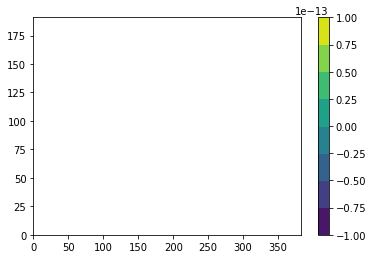

In [29]:
plt.figure()
cs=plt.contourf(np.transpose(T[2,:,:]))
plt.colorbar(cs)

In [ ]:
f = h5py.File('snapshots/snapshots.h5', 'r')
T = f['tasks']['T']
np.shape(T)
for t in range(0,140,10):
    fig=plt.figure(figsize=(8.5, 3), dpi=300)
    cs=plt.contourf(np.transpose(T[t,:,:]-np.mean(T[t,:,:],axis=0)),np.arange(-0.1,0.1005,0.005),cmap='seismic',extend='both')
    plt.colorbar(cs)
    fig.savefig('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/t_'+str(t).zfill(4)+'.png', dpi=150, bbox_inches='tight')
    plt.close(fig) 

/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/t_*.png"
fp_out = "/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=10, loop=0)


In [ ]:
!ls /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif

/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif


In [ ]:
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]
    print(np.shape(T))

(5000, 128, 64)


In [ ]:
np.array(T[0].T)

ValueError: ignored

In [ ]:
#Analysis 1 
#Convection plotting using temperature 
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(7, 6), dpi=100)
    quad = plt.pcolormesh(x, z, T[0].T, shading='nearest', cmap='coolwarm',vmin=0,vmax=1e-1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=T[:])
    animation.save('convection.gif',fps=200)



2022-03-21 02:59:21,625 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-03-21 02:59:21,629 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 700x600 -pix_fmt rgba -r 200 -i pipe: -vcodec h264 -pix_fmt yuv420p -y convection.gif
2022-03-21 02:59:21,825 matplotlib.animation 0/1 WARNING :: MovieWriter stderr:
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgs

CalledProcessError: ignored

ValueError: ignored

<Figure size 700x600 with 2 Axes>

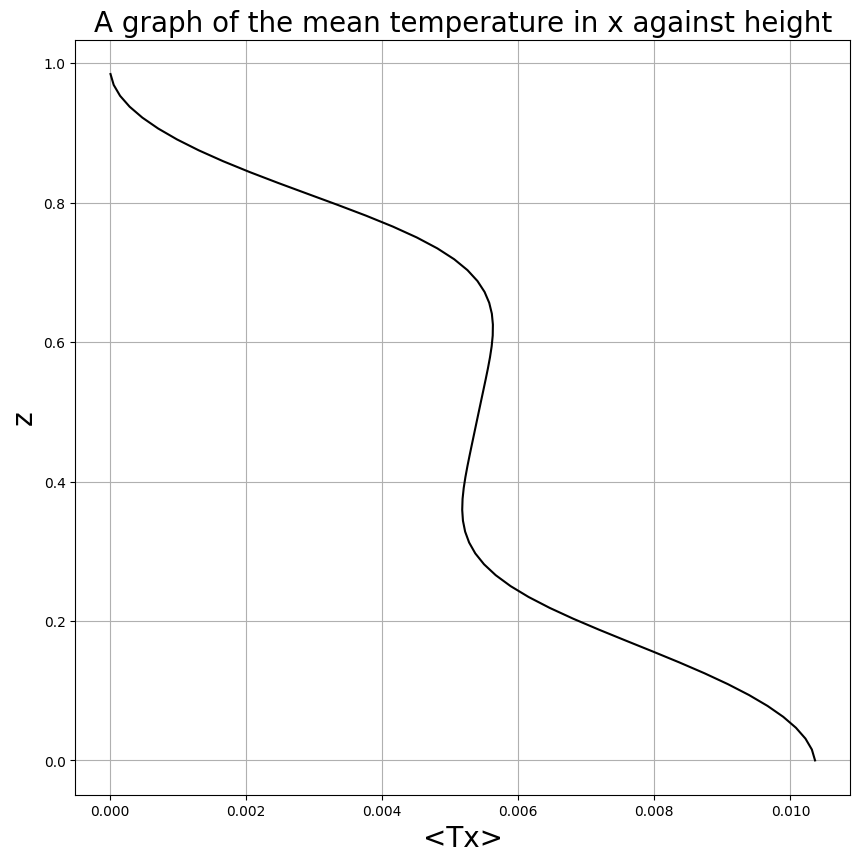

In [ ]:
#Analysis 2
#Plotting average temperature as a function of height
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    #Load analysis datasets:
    Tx = file['tasks']['<Tx>']
    z = np.arange(0.,d,1/zres)
    t = Tx.dims[0]

    #Plot data
    fig = plt.figure(figsize=(10,10), dpi=100)
    quad = plt.plot(Tx[-1][0][:],z,'black')
    plt.title('A graph of the mean temperature in x against height',fontsize=20)
    plt.grid()
    plt.xlabel('<Tx>',fontsize=20)
    plt.ylabel('z',fontsize=20)
    plt.savefig("meantemp.jpeg")

In [ ]:
#Analysis 3
#Convection plotting using kinetic energy
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    KE = file['tasks']['KE']
    t = KE.dims[0]['sim_time']
    x =KE.dims[1][0]
    z = KE.dims[2][0]

    KEmax = np.max(KE[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, KE[0].T, shading='nearest', cmap='inferno',vmin = 0,vmax=0. 95 * KEmax)
    plt.colorbar(label='Kinetic Energy')
    plt.title('A graph showing the kinetic energy of \na fluid in Rayleigh-Bernard convection through time')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=KE[:])
    animation.save('KEconvection.gif',fps=200)

In [ ]:
#Analysis 4
#Convection plotting using momentum
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    uvec = file['tasks']['|uvec|']
    t = uvec.dims[0]['sim_time']
    x =uvec.dims[1][0]
    z = uvec.dims[2][0]

    uvecmax = np.max(uvec[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, uvec[0].T, shading='nearest', cmap='inferno', vmin = 0, vmax= 0.95 * uvecmax)
    plt.colorbar(label='|u|')
    plt.title(' ')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=uvec[:])
    animation.save('uvec_convection.gif',fps=200)